# PhysioNet Motor Imagery - Complete Consolidated Comparison (OPTIMIZED)

## All Methods: Baseline, Gated CARM, CARMv2, SparseGCN-CARM

This notebook provides a comprehensive comparison of all four channel selection methods:

1. **Baseline EEG-ARNN**: Pure CNN-GCN architecture
2. **Gated CARM**: Learnable channel gates with L1 sparsity
3. **CARMv2**: Feature-based adaptive adjacency with 2-hop propagation
4. **SparseGCN-CARM**: Multi-head attention + multi-scale temporal

**OPTIMIZED FOR SPEED**: ~2 hours runtime on GPU
- 10 subjects (instead of 20)
- 20 epochs (instead of 40)
- 4 k values: [10, 20, 30, 40]
- 2 selection methods per model (best ones)
- Larger batch size (64) for faster training

**Still includes**: 15+ comprehensive visualizations and detailed statistical analysis

## 1. Setup and Imports

In [1]:
import json
import random
import warnings
from pathlib import Path
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from scipy import stats

import mne

warnings.filterwarnings('ignore')
sns.set_context('notebook', font_scale=1.0)
sns.set_style('whitegrid')
mne.set_log_level('WARNING')

def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## 2. Configuration

In [2]:
# Auto-detect Kaggle environment
import os
if os.path.exists('/kaggle/input'):
    print("Running on Kaggle")
    kaggle_input = Path("/kaggle/input")
    datasets = [d for d in kaggle_input.iterdir() if d.is_dir()]
    print(f"Available datasets: {[d.name for d in datasets]}")
    
    DATA_DIR = None
    possible_names = ['physioneteegmi', 'eeg-motor-movementimagery-dataset']
    for ds_name in possible_names:
        test_path = kaggle_input / ds_name
        if test_path.exists():
            DATA_DIR = test_path
            print(f"Found dataset: {DATA_DIR}")
            break
    
    if DATA_DIR is None and datasets:
        DATA_DIR = datasets[0]
        print(f"Using first available dataset: {DATA_DIR}")
else:
    print("Running locally")
    DATA_DIR = Path('data/physionet/files')

CONFIG = {
    'data': {
        'raw_data_dir': DATA_DIR,
        'selected_classes': [1, 2],
        'tmin': -1.0,
        'tmax': 5.0,
        'baseline': (-0.5, 0)
    },
    'preprocessing': {
        'l_freq': 0.5,
        'h_freq': 40.0,
        'notch_freq': 50.0,
        'target_sfreq': 128.0,
        'apply_car': True
    },
    'model': {
        'hidden_dim': 40,
        'epochs': 20,
        'learning_rate': 1e-3,
        'batch_size': 64,
        'n_folds': 3,
        'patience': 5
    },
    'gated': {
        'l1_lambda': 1e-3,
        'gate_init': 0.9
    },
    'carmv2': {
        'topk_k': 8,
        'lambda_feat': 0.3,
        'hop_alpha': 0.5,
        'edge_dropout': 0.1,
        'use_pairnorm': True,
        'use_residual': True,
        'low_rank_r': 0
    },
    'sparsegcn': {
        'topk_k': 8,
        'lambda_feat': 0.3,
        'hop_alpha': 0.5,
        'edge_dropout': 0.1,
        'use_pairnorm': True,
        'use_residual': True,
        'use_channel_attention': True,
        'attention_heads': 4,
        'prune_enabled': False,
        'prune_start_epoch': 10,
        'prune_every': 2,
        'prune_ratio': 0.05,
        'min_channels': 20,
        'temporal_scales': [8, 16, 32],
        'channel_importance_loss': 1e-3
    },
    'channel_selection': {
        'k_values': [10, 20, 30, 40]
    },
    'output': {
        'results_dir': Path('results'),
    },
    'max_subjects': 10,
    'min_runs_per_subject': 8
}

CONFIG['output']['results_dir'].mkdir(exist_ok=True, parents=True)
print("OPTIMIZED Configuration loaded!")
print(f"Training: {CONFIG['max_subjects']} subjects, {CONFIG['model']['n_folds']}-fold CV, {CONFIG['model']['epochs']} epochs")
print(f"Channel selection: {CONFIG['channel_selection']['k_values']}")
print(f"Batch size: {CONFIG['model']['batch_size']} (faster), Patience: {CONFIG['model']['patience']}")
print("Estimated runtime: ~2 hours on GPU")

Running on Kaggle
Available datasets: ['physioneteegmi']
Found dataset: /kaggle/input/physioneteegmi
OPTIMIZED Configuration loaded!
Training: 10 subjects, 3-fold CV, 20 epochs
Channel selection: [10, 20, 30, 40]
Batch size: 64 (faster), Patience: 5
Estimated runtime: ~2 hours on GPU


## 3. Data Cleaning - Excluded Subjects

In [3]:
# Known faulty subjects from data cleaning analysis
KNOWN_BAD_SUBJECTS = [
    'S088', 'S089', 'S092', 'S100', 'S104', 'S106', 'S107', 'S108', 'S109'
]

# Additional subjects with high clipping or amplitude issues
HIGH_ISSUE_SUBJECTS = [
    'S003', 'S004', 'S009', 'S010', 'S012', 'S013', 'S017', 'S018', 'S019',
    'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029'
]

EXCLUDED_SUBJECTS = set(KNOWN_BAD_SUBJECTS + HIGH_ISSUE_SUBJECTS)

print(f"Total excluded subjects: {len(EXCLUDED_SUBJECTS)}")
print(f"Excluded: {sorted(EXCLUDED_SUBJECTS)}")

Total excluded subjects: 27
Excluded: ['S003', 'S004', 'S009', 'S010', 'S012', 'S013', 'S017', 'S018', 'S019', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S088', 'S089', 'S092', 'S100', 'S104', 'S106', 'S107', 'S108', 'S109']


## 4. Data Loading and Preprocessing Functions

In [4]:
def preprocess_raw(raw, config):
    """Apply preprocessing to raw EEG data."""
    cleaned_names = {name: name.rstrip('.') for name in raw.ch_names}
    raw.rename_channels(cleaned_names)
    raw.pick_types(eeg=True)
    raw.set_montage('standard_1020', on_missing='ignore', match_case=False)
    
    nyquist = raw.info['sfreq'] / 2.0
    if config['preprocessing']['notch_freq'] < nyquist:
        raw.notch_filter(freqs=config['preprocessing']['notch_freq'], verbose=False)
    
    raw.filter(
        l_freq=config['preprocessing']['l_freq'],
        h_freq=config['preprocessing']['h_freq'],
        method='fir',
        fir_design='firwin',
        verbose=False
    )
    
    if config['preprocessing']['apply_car']:
        raw.set_eeg_reference('average', projection=False, verbose=False)
    
    raw.resample(config['preprocessing']['target_sfreq'], npad='auto', verbose=False)
    return raw


def load_and_preprocess_edf(edf_path, config):
    """Load raw EDF file, preprocess it, and extract epochs."""
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')
    raw = preprocess_raw(raw, config)
    
    try:
        events = mne.find_events(raw, verbose='ERROR')
        event_ids = {f'T{i}': i for i in np.unique(events[:, 2])}
        assert len(events) > 0
    except Exception:
        events, event_ids = mne.events_from_annotations(raw, verbose='ERROR')
    
    if len(events) == 0:
        return None, None, raw.ch_names
    
    epochs = mne.Epochs(
        raw,
        events,
        event_id=event_ids,
        tmin=config['data']['tmin'],
        tmax=config['data']['tmax'],
        baseline=tuple(config['data']['baseline']),
        preload=True,
        verbose='ERROR'
    )
    
    return epochs.get_data(), epochs.events[:, 2], raw.ch_names


def filter_classes(x, y, selected_classes):
    """Filter to keep only selected classes and remap labels."""
    mask = np.isin(y, selected_classes)
    y, x = y[mask], x[mask]
    label_map = {old: new for new, old in enumerate(sorted(selected_classes))}
    y = np.array([label_map[int(label)] for label in y], dtype=np.int64)
    return x, y


def normalize(x):
    """Z-score normalization per channel."""
    mu = x.mean(axis=(0, 2), keepdims=True)
    sd = x.std(axis=(0, 2), keepdims=True) + 1e-8
    return (x - mu) / sd


def load_subject_data(data_dir, subject_id, run_ids, config):
    """Load all runs for a subject, preprocess, and concatenate."""
    subject_dir = data_dir / subject_id
    if not subject_dir.exists():
        return None, None, None
    
    all_x, all_y = [], []
    channel_names = None
    
    for run_id in run_ids:
        edf_path = subject_dir / f'{subject_id}{run_id}.edf'
        if not edf_path.exists():
            continue
        
        try:
            x, y, ch_names = load_and_preprocess_edf(edf_path, config)
            if x is None or len(y) == 0:
                continue
            
            x, y = filter_classes(x, y, config['data']['selected_classes'])
            if len(y) == 0:
                continue
            
            channel_names = channel_names or ch_names
            all_x.append(x)
            all_y.append(y)
        except Exception as e:
            continue
    
    if len(all_x) == 0:
        return None, None, channel_names
    
    return np.concatenate(all_x, 0), np.concatenate(all_y, 0), channel_names


def get_available_subjects(data_dir, min_runs=8, excluded=None):
    """Get list of subjects with at least min_runs available, excluding bad subjects."""
    if not data_dir.exists():
        raise ValueError(f"Data directory not found: {data_dir}")
    
    excluded = excluded or set()
    subjects = []
    
    for subject_dir in sorted(data_dir.iterdir()):
        if not subject_dir.is_dir() or not subject_dir.name.startswith('S'):
            continue
        
        if subject_dir.name in excluded:
            continue
        
        edf_files = list(subject_dir.glob('*.edf'))
        if len(edf_files) >= min_runs:
            subjects.append(subject_dir.name)
    
    return subjects


# Scan for available subjects
print("\nScanning for subjects...")
data_dir = CONFIG['data']['raw_data_dir']
print(f"Looking for data in: {data_dir}")

all_subjects = get_available_subjects(
    data_dir, 
    min_runs=CONFIG['min_runs_per_subject'],
    excluded=EXCLUDED_SUBJECTS
)
subjects = all_subjects[:CONFIG['max_subjects']]

print(f"Found {len(all_subjects)} clean subjects")
print(f"Will process {len(subjects)} subjects: {subjects}")

# Define which runs to use
MOTOR_IMAGERY_RUNS = ['R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']
MOTOR_EXECUTION_RUNS = ['R03', 'R04', 'R05', 'R06']
ALL_TASK_RUNS = MOTOR_IMAGERY_RUNS + MOTOR_EXECUTION_RUNS
print(f"Using runs: {ALL_TASK_RUNS}")


Scanning for subjects...
Looking for data in: /kaggle/input/physioneteegmi
Found 82 clean subjects
Will process 10 subjects: ['S001', 'S002', 'S005', 'S006', 'S007', 'S008', 'S011', 'S014', 'S015', 'S016']
Using runs: ['R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14', 'R03', 'R04', 'R05', 'R06']


## 5. PyTorch Dataset

In [5]:
class EEGDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x).unsqueeze(1)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

## 6. Model Architectures

### 6.1 Baseline EEG-ARNN

In [6]:
class GraphConvLayer(nn.Module):
    """Graph Convolution Layer with learned adjacency."""
    def __init__(self, num_channels, hidden_dim):
        super().__init__()
        self.num_channels = num_channels
        self.hidden_dim = hidden_dim
        
        self.A = nn.Parameter(torch.randn(num_channels, num_channels))
        self.theta = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.bn = nn.BatchNorm2d(hidden_dim)
        self.act = nn.ELU()
    
    def forward(self, x):
        B, H, C, T = x.shape
        
        A = torch.sigmoid(self.A)
        A = 0.5 * (A + A.t())
        I = torch.eye(C, device=A.device)
        A_hat = A + I
        D = torch.diag(torch.pow(A_hat.sum(1).clamp_min(1e-6), -0.5))
        A_norm = D @ A_hat @ D
        
        x_batch = x.permute(0, 3, 2, 1).contiguous().view(B*T, C, H)
        x_g = A_norm @ x_batch
        x_g = self.theta(x_g)
        x_g = x_g.view(B, T, C, H).permute(0, 3, 2, 1)
        
        x_out = self.bn(x_g)
        x_out = self.act(x_out)
        
        return x_out
    
    def get_adjacency(self):
        with torch.no_grad():
            A = torch.sigmoid(self.A)
            A = 0.5 * (A + A.t())
            return A.cpu().numpy()


class TemporalConv(nn.Module):
    """Temporal Convolution Layer."""
    def __init__(self, in_channels, out_channels, kernel_size=16, pool=True):
        super().__init__()
        self.pool = pool
        self.conv = nn.Conv2d(in_channels, out_channels, 
                            kernel_size=(1, kernel_size), 
                            padding=(0, kernel_size//2), bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ELU()
        self.pool_layer = nn.AvgPool2d(kernel_size=(1, 2)) if pool else None
    
    def forward(self, x):
        x = self.act(self.bn(self.conv(x)))
        return self.pool_layer(x) if self.pool else x


class BaselineEEGARNN(nn.Module):
    """Baseline EEG-ARNN with pure CNN-GCN architecture."""
    def __init__(self, C, T, K, H):
        super().__init__()
        self.t1 = TemporalConv(1, H, 16, False)
        self.g1 = GraphConvLayer(C, H)
        self.t2 = TemporalConv(H, H, 16, True)
        self.g2 = GraphConvLayer(C, H)
        self.t3 = TemporalConv(H, H, 16, True)
        self.g3 = GraphConvLayer(C, H)
        
        with torch.no_grad():
            ft = self._forward_features(torch.zeros(1, 1, C, T))
            fs = ft.view(1, -1).size(1)
        
        self.fc1 = nn.Linear(fs, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, K)
    
    def _forward_features(self, x):
        x = self.g1(self.t1(x))
        x = self.g2(self.t2(x))
        x = self.g3(self.t3(x))
        return x
    
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)
    
    def get_final_adjacency(self):
        return self.g3.get_adjacency()


print("Baseline EEG-ARNN defined!")

Baseline EEG-ARNN defined!


### 6.2 Gated CARM

In [7]:
class GatedEEGARNN(BaselineEEGARNN):
    """EEG-ARNN with learnable channel gates."""
    def __init__(self, C, T, K, H, gate_init=0.9):
        super().__init__(C, T, K, H)
        init = torch.full((C,), float(gate_init), dtype=torch.float32)
        init = torch.clamp(init, 1e-4, 1 - 1e-4)
        gate_logits = torch.logit(init)
        self.gate_logits = nn.Parameter(gate_logits)
        self.latest_gates = None
    
    def get_gate_values(self):
        return torch.sigmoid(self.gate_logits)
    
    def forward(self, x):
        gate_values = torch.sigmoid(self.gate_logits)
        self.latest_gates = gate_values.detach().cpu()
        x = x * gate_values.view(1, 1, -1, 1)
        return super().forward(x)


print("Gated CARM defined!")

Gated CARM defined!


### 6.3 CARMv2

In [8]:
def pairnorm(x, node_dim=2, eps=1e-6):
    m = x.mean(dim=node_dim, keepdim=True)
    xc = x - m
    v = (xc * xc).mean(dim=node_dim, keepdim=True)
    return xc / torch.sqrt(v + eps)


def build_feat_topk_adj(x, k, active_channels=None):
    B, H, C, T = x.shape
    
    if active_channels is not None:
        mask = active_channels.view(C, 1).to(x.device)
        x_masked = x * mask.view(1, 1, C, 1)
    else:
        x_masked = x
    
    E = x_masked.permute(2, 1, 0, 3).contiguous().view(C, H, B*T).mean(2)
    En = F.normalize(E, p=2, dim=1)
    S = (En @ En.t()).clamp_min(0.0)
    k = max(1, min(int(k), C))
    vals, idx = torch.topk(S, k, dim=1)
    M = torch.zeros_like(S)
    M.scatter_(1, idx, 1.0)
    A = S * M
    A = torch.softmax(A, 1)
    A = 0.5 * (A + A.t())
    return A


class CARMv2Layer(nn.Module):
    def __init__(self, C, H, cfg):
        super().__init__()
        self.C = C
        self.H = H
        self.k = int(cfg['topk_k'])
        self.lf = float(cfg['lambda_feat'])
        self.ha = float(cfg['hop_alpha'])
        self.ed = float(cfg['edge_dropout'])
        self.pn = bool(cfg['use_pairnorm'])
        self.res = bool(cfg['use_residual'])
        r = int(cfg['low_rank_r'])
        
        if r > 0:
            self.B = nn.Parameter(torch.empty(C, r))
            nn.init.xavier_uniform_(self.B)
            self.W = None
        else:
            self.W = nn.Parameter(torch.empty(C, C))
            nn.init.xavier_uniform_(self.W)
            self.B = None
        
        self.th = nn.Linear(H, H, bias=False)
        self.bn = nn.BatchNorm2d(H)
        self.act = nn.ELU()
        self.last = None
    
    def _learned(self, dev, active_channels=None):
        W = self.W if self.B is None else (self.B @ self.B.t())
        A = torch.sigmoid(W)
        A = 0.5 * (A + A.t())
        
        if active_channels is not None:
            mask = active_channels.view(self.C, 1).to(dev)
            A = A * mask * mask.t()
        
        I = torch.eye(self.C, device=dev, dtype=A.dtype)
        At = A + I
        d = torch.pow(At.sum(1).clamp_min(1e-6), -0.5)
        D = torch.diag(d)
        return D @ At @ D
    
    def forward(self, x, active_channels=None):
        B, H, C, T = x.shape
        Al = self._learned(x.device, active_channels)
        A2 = Al @ Al
        Ah = (1 - self.ha) * Al + self.ha * A2
        Af = build_feat_topk_adj(x, self.k, active_channels)
        A = (1 - self.lf) * Ah + self.lf * Af
        
        if self.training and self.ed > 0:
            M = (torch.rand_like(A) > self.ed).float()
            A = 0.5 * ((A * M) + (A * M).t())
            A = A + torch.eye(C, device=A.device, dtype=A.dtype)
        
        d = torch.pow(A.sum(1).clamp_min(1e-6), -0.5)
        D = torch.diag(d)
        A = D @ A @ D
        
        xb = x.permute(0, 3, 2, 1).contiguous().view(B*T, C, H)
        xg = A @ xb
        xg = self.th(xg)
        xg = xg.view(B, T, C, H).permute(0, 3, 2, 1)
        
        if self.res:
            if active_channels is not None:
                x_res = x * active_channels.view(1, 1, C, 1)
            else:
                x_res = x
            out = xg + x_res
        else:
            out = xg
        out = pairnorm(out, 2) if self.pn else out
        out = self.bn(out)
        out = self.act(out)
        
        self.last = {'learned': Al.detach().cpu().numpy()}
        return out
    
    def get_adjs(self):
        return self.last or {}


class CARMv2Model(nn.Module):
    def __init__(self, C, T, K, H, cfg):
        super().__init__()
        self.t1 = TemporalConv(1, H, 16, False)
        self.g1 = CARMv2Layer(C, H, cfg)
        self.t2 = TemporalConv(H, H, 16, True)
        self.g2 = CARMv2Layer(C, H, cfg)
        self.t3 = TemporalConv(H, H, 16, True)
        self.g3 = CARMv2Layer(C, H, cfg)
        
        with torch.no_grad():
            ft = self._f(torch.zeros(1, 1, C, T))
            fs = ft.view(1, -1).size(1)
        
        self.fc1 = nn.Linear(fs, 256)
        self.do = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, K)
    
    def _f(self, x):
        x = self.g1(self.t1(x))
        x = self.g2(self.t2(x))
        x = self.g3(self.t3(x))
        return x
    
    def forward(self, x):
        x = self._f(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.do(x)
        return self.fc2(x)
    
    def get_final_adjacency(self):
        adjs = self.g3.get_adjs()
        return adjs.get('learned', None)


print("CARMv2 defined!")

CARMv2 defined!


### 6.4 SparseGCN-CARM

In [9]:
class ChannelAttention(nn.Module):
    """Multi-head channel attention module."""
    def __init__(self, num_channels, num_heads=4):
        super().__init__()
        self.num_channels = num_channels
        self.num_heads = num_heads
        self.head_dim = max(1, num_channels // num_heads)
        
        self.channel_embed = nn.Parameter(torch.randn(num_channels, self.head_dim * num_heads))
        nn.init.xavier_uniform_(self.channel_embed)
        
        self.query = nn.Linear(self.head_dim * num_heads, self.head_dim * num_heads)
        self.key = nn.Linear(self.head_dim * num_heads, self.head_dim * num_heads)
        
        self.importance_proj = nn.Sequential(
            nn.Linear(self.head_dim * num_heads, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x=None):
        embed = self.channel_embed
        
        Q = self.query(embed)
        K = self.key(embed)
        
        Q = Q.view(self.num_channels, self.num_heads, self.head_dim)
        K = K.view(self.num_channels, self.num_heads, self.head_dim)
        
        attn = torch.einsum('chd,khd->chk', Q, K) / np.sqrt(self.head_dim)
        attn = F.softmax(attn, dim=-1)
        
        attn_pooled = attn.mean(dim=1)
        channel_scores = attn_pooled.sum(dim=1)
        channel_scores = channel_scores / channel_scores.sum()
        
        importance = self.importance_proj(embed).squeeze(-1) if embed.dim() > 1 else self.importance_proj(embed)
        
        final_importance = 0.5 * channel_scores + 0.5 * importance
        final_importance = final_importance / (final_importance.sum() + 1e-8)
        
        return final_importance, attn


class MultiScaleTemporalConv(nn.Module):
    """Multi-scale temporal convolution."""
    def __init__(self, in_channels, out_channels, kernel_sizes=[8, 16, 32], pool=True):
        super().__init__()
        self.pool = pool
        k_num = len(kernel_sizes)
        base = out_channels // k_num
        rem = out_channels - base * k_num
        out_list = [base + (1 if i < rem else 0) for i in range(k_num)]
        
        branches = []
        for i, k in enumerate(kernel_sizes):
            oc = out_list[i]
            branches.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, oc, kernel_size=(1, k), padding=(0, k//2), bias=False),
                    nn.BatchNorm2d(oc),
                    nn.ELU()
                )
            )
        self.branches = nn.ModuleList(branches)
        self.pool_layer = nn.AvgPool2d(kernel_size=(1, 2)) if pool else None
    
    def forward(self, x):
        branch_outputs = [branch(x) for branch in self.branches]
        x = torch.cat(branch_outputs, dim=1)
        return self.pool_layer(x) if self.pool else x


class AdaptiveGCNLayer(nn.Module):
    """Adaptive GCN layer from CARMv2."""
    def __init__(self, C, H, topk_k=8, lambda_feat=0.3, hop_alpha=0.5, edge_dropout=0.1,
                 use_pairnorm=True, use_residual=True):
        super().__init__()
        self.C = C
        self.H = H
        self.k = topk_k
        self.lf = lambda_feat
        self.ha = hop_alpha
        self.ed = edge_dropout
        self.pn = use_pairnorm
        self.res = use_residual
        
        self.W = nn.Parameter(torch.empty(C, C))
        nn.init.xavier_uniform_(self.W)
        
        self.th = nn.Linear(H, H, bias=False)
        self.bn = nn.BatchNorm2d(H)
        self.act = nn.ELU()
        self.last = None
    
    def _learned(self, dev, active_channels=None):
        A = torch.sigmoid(self.W)
        A = 0.5 * (A + A.t())
        
        if active_channels is not None:
            mask = active_channels.view(self.C, 1).to(dev)
            A = A * mask * mask.t()
        
        I = torch.eye(self.C, device=dev, dtype=A.dtype)
        At = A + I
        d = torch.pow(At.sum(1).clamp_min(1e-6), -0.5)
        D = torch.diag(d)
        return D @ At @ D
    
    def forward(self, x, active_channels=None):
        B, H, C, T = x.shape
        
        Al = self._learned(x.device, active_channels)
        A2 = Al @ Al
        Ah = (1 - self.ha) * Al + self.ha * A2
        Af = build_feat_topk_adj(x, self.k, active_channels)
        A = (1 - self.lf) * Ah + self.lf * Af
        
        if self.training and self.ed > 0:
            M = (torch.rand_like(A) > self.ed).float()
            A = 0.5 * ((A * M) + (A * M).t())
            A = A + torch.eye(C, device=A.device, dtype=A.dtype)
        
        d = torch.pow(A.sum(1).clamp_min(1e-6), -0.5)
        D = torch.diag(d)
        A = D @ A @ D
        
        xb = x.permute(0, 3, 2, 1).contiguous().view(B*T, C, H)
        xg = A @ xb
        xg = self.th(xg)
        xg = xg.view(B, T, C, H).permute(0, 3, 2, 1)
        
        if self.res:
            if active_channels is not None:
                x_res = x * active_channels.view(1, 1, C, 1)
            else:
                x_res = x
            out = xg + x_res
        else:
            out = xg
        out = pairnorm(out, 2) if self.pn else out
        out = self.bn(out)
        out = self.act(out)
        
        self.last = {'learned': Al.detach().cpu().numpy()}
        return out


class SparseGCNCARMModel(nn.Module):
    """SparseGCN-CARM with multi-head attention and progressive pruning."""
    def __init__(self, C, T, K, H, config):
        super().__init__()
        self.C = C
        self.config = config
        
        if config.get('use_channel_attention', True):
            self.channel_attention = ChannelAttention(C, config.get('attention_heads', 4))
        else:
            self.channel_attention = None
        
        scales = config.get('temporal_scales', [8, 16, 32])
        self.t1 = MultiScaleTemporalConv(1, H, scales, False)
        self.g1 = AdaptiveGCNLayer(C, H, config.get('topk_k', 8), config.get('lambda_feat', 0.3),
                                   config.get('hop_alpha', 0.5), config.get('edge_dropout', 0.1),
                                   config.get('use_pairnorm', True), config.get('use_residual', True))
        self.t2 = MultiScaleTemporalConv(H, H, scales, True)
        self.g2 = AdaptiveGCNLayer(C, H, config.get('topk_k', 8), config.get('lambda_feat', 0.3),
                                   config.get('hop_alpha', 0.5), config.get('edge_dropout', 0.1),
                                   config.get('use_pairnorm', True), config.get('use_residual', True))
        self.t3 = MultiScaleTemporalConv(H, H, scales, True)
        self.g3 = AdaptiveGCNLayer(C, H, config.get('topk_k', 8), config.get('lambda_feat', 0.3),
                                   config.get('hop_alpha', 0.5), config.get('edge_dropout', 0.1),
                                   config.get('use_pairnorm', True), config.get('use_residual', True))
        
        with torch.no_grad():
            ft = self._forward_features(torch.zeros(1, 1, C, T), None)
            fs = ft.view(1, -1).size(1)
        
        self.fc1 = nn.Linear(fs, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, K)
        
        self.register_buffer('active_channels', torch.ones(C))
        self.channel_importance = None
    
    def _forward_features(self, x, active_channels):
        x = self.g1(self.t1(x), active_channels)
        x = self.g2(self.t2(x), active_channels)
        x = self.g3(self.t3(x), active_channels)
        return x
    
    def forward(self, x):
        if self.channel_attention is not None:
            importance, attn = self.channel_attention(x)
            self.channel_importance = importance
            
            if self.training:
                x = x * importance.view(1, 1, self.C, 1)
        
        x = self._forward_features(x, self.active_channels)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)
    
    def prune_channels(self, prune_ratio, min_channels=20):
        if self.channel_importance is None:
            return 0
        
        num_active = int(self.active_channels.sum().item())
        num_to_prune = max(1, int(num_active * prune_ratio))
        
        if num_active - num_to_prune < min_channels:
            return 0
        
        importance = self.channel_importance.detach().cpu()
        active_importance = importance * self.active_channels.cpu()
        
        _, sorted_indices = torch.sort(active_importance)
        
        pruned = 0
        for idx in sorted_indices:
            if self.active_channels[idx] > 0:
                self.active_channels[idx] = 0
                pruned += 1
                if pruned >= num_to_prune:
                    break
        
        return pruned
    
    def get_channel_importance(self):
        if self.channel_importance is not None:
            return self.channel_importance.detach().cpu().numpy()
        return None
    
    def get_active_channels_mask(self):
        return self.active_channels.cpu().numpy()
    
    def get_final_adjacency(self):
        return self.g3.last.get('learned', None) if self.g3.last else None


print("SparseGCN-CARM defined!")

SparseGCN-CARM defined!


## 7. Training Functions

In [10]:
def train_epoch(model, dataloader, criterion, optimizer, device, config, model_type):
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        
        # Add regularization
        if model_type == 'gated' and hasattr(model, 'get_gate_values'):
            l1_lambda = config['gated']['l1_lambda']
            gate_values = model.get_gate_values()
            loss = loss + l1_lambda * gate_values.abs().mean()
        elif model_type == 'sparsegcn' and hasattr(model, 'channel_importance'):
            if model.channel_importance is not None:
                importance_loss = config['sparsegcn']['channel_importance_loss'] * model.channel_importance.abs().mean()
                loss = loss + importance_loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_preds += torch.argmax(logits, 1).cpu().tolist()
        all_labels += y.cpu().tolist()
    
    return total_loss / max(1, len(dataloader)), accuracy_score(all_labels, all_preds)


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        
        total_loss += loss.item()
        all_preds += torch.argmax(logits, 1).cpu().tolist()
        all_labels += y.cpu().tolist()
    
    return total_loss / max(1, len(dataloader)), accuracy_score(all_labels, all_preds)


def train_model(model, train_loader, val_loader, device, config, model_type):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['model']['learning_rate'], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=False
    )
    
    best_acc = 0.0
    best_state = None
    no_improve = 0
    
    # Progressive pruning for SparseGCN
    prune_enabled = False
    if model_type == 'sparsegcn' and hasattr(model, 'prune_channels'):
        prune_enabled = config['sparsegcn'].get('prune_enabled', True)
        prune_start = config['sparsegcn'].get('prune_start_epoch', 10)
        prune_every = config['sparsegcn'].get('prune_every', 2)
        prune_ratio = config['sparsegcn'].get('prune_ratio', 0.05)
        min_channels = config['sparsegcn'].get('min_channels', 20)
    
    for epoch in range(config['model']['epochs']):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, config, model_type)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        scheduler.step(val_loss)
        
        # Progressive pruning
        if prune_enabled and epoch >= prune_start and (epoch - prune_start) % prune_every == 0:
            num_pruned = model.prune_channels(prune_ratio, min_channels)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= config['model']['patience']:
            break
    
    if best_state is None:
        best_state = deepcopy(model.state_dict())
    
    model.load_state_dict(best_state)
    return best_state, best_acc


print("Training functions defined!")

Training functions defined!


## 8. Cross-Validation Function

In [11]:
def cross_validate_subject(x, y, channel_names, T, K, device, config, model_type):
    """Cross-validate subject with specified model type."""
    C = x.shape[1]
    H = config['model']['hidden_dim']
    skf = StratifiedKFold(n_splits=config['model']['n_folds'], shuffle=True, random_state=42)
    
    folds = []
    adjacencies = []
    gate_values_list = []
    importance_values_list = []
    active_channels_list = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(x, y)):
        X_train, X_val = normalize(x[train_idx]), normalize(x[val_idx])
        Y_train, Y_val = y[train_idx], y[val_idx]
        
        train_loader = DataLoader(
            EEGDataset(X_train, Y_train),
            batch_size=config['model']['batch_size'],
            shuffle=True,
            num_workers=0
        )
        val_loader = DataLoader(
            EEGDataset(X_val, Y_val),
            batch_size=config['model']['batch_size'],
            shuffle=False,
            num_workers=0
        )
        
        # Create model
        if model_type == 'baseline':
            model = BaselineEEGARNN(C, T, K, H).to(device)
        elif model_type == 'gated':
            model = GatedEEGARNN(C, T, K, H, config['gated']['gate_init']).to(device)
        elif model_type == 'carmv2':
            model = CARMv2Model(C, T, K, H, config['carmv2']).to(device)
        elif model_type == 'sparsegcn':
            model = SparseGCNCARMModel(C, T, K, H, config['sparsegcn']).to(device)
        else:
            raise ValueError(f"Unknown model type: {model_type}")
        
        best_state, best_acc = train_model(model, train_loader, val_loader, device, config, model_type)
        model.load_state_dict(best_state)
        
        _, accuracy = evaluate(model, val_loader, nn.CrossEntropyLoss(), device)
        
        adjacency = model.get_final_adjacency()
        adjacencies.append(adjacency)
        
        if model_type == 'gated':
            gate_values = model.get_gate_values().detach().cpu().numpy()
            gate_values_list.append(gate_values)
        elif model_type == 'sparsegcn':
            importance = model.get_channel_importance()
            active_mask = model.get_active_channels_mask()
            if importance is not None:
                importance_values_list.append(importance)
            active_channels_list.append(int(active_mask.sum()))
        
        folds.append({'fold': fold, 'val_acc': accuracy})
    
    avg_acc = float(np.mean([f['val_acc'] for f in folds]))
    std_acc = float(np.std([f['val_acc'] for f in folds]))
    avg_adjacency = np.mean(np.stack([a for a in adjacencies if a is not None], 0), 0) \
                    if any(a is not None for a in adjacencies) else None
    
    result = {
        'fold_results': folds,
        'avg_accuracy': avg_acc,
        'std_accuracy': std_acc,
        'adjacency_matrix': avg_adjacency,
        'channel_names': channel_names
    }
    
    if model_type == 'gated' and gate_values_list:
        result['avg_gate_values'] = np.mean(np.stack(gate_values_list, 0), 0)
    elif model_type == 'sparsegcn':
        if importance_values_list:
            result['avg_importance'] = np.mean(np.stack(importance_values_list, 0), 0)
        if active_channels_list:
            result['avg_active_channels'] = np.mean(active_channels_list)
    
    return result


print("Cross-validation function defined!")

Cross-validation function defined!


## 9. Main Training Loop - All Four Methods

In [12]:
all_results = {'baseline': [], 'gated': [], 'carmv2': [], 'sparsegcn': []}

print("\n" + "="*80)
print("TRAINING ALL FOUR METHODS")
print("="*80 + "\n")

for subject_id in tqdm(subjects, desc='Training subjects'):
    print(f"\nProcessing {subject_id}...")
    
    X, Y, channel_names = load_subject_data(data_dir, subject_id, ALL_TASK_RUNS, CONFIG)
    
    if X is None or len(Y) == 0:
        print(f"  Skipped: No data available")
        continue
    
    C, T = X.shape[1], X.shape[2]
    K = len(set(CONFIG['data']['selected_classes']))
    
    print(f"  Data: {X.shape}, Classes: {K}")
    
    # Train all four methods
    for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
        print(f"  Training {model_type.upper()}...", end=' ')
        result = cross_validate_subject(X, Y, channel_names, T, K, device, CONFIG, model_type)
        
        print(f"{result['avg_accuracy']:.4f} Â± {result['std_accuracy']:.4f}", end='')
        
        result_dict = {
            'subject': subject_id,
            'num_trials': X.shape[0],
            'num_channels': C,
            'accuracy': result['avg_accuracy'],
            'std': result['std_accuracy'],
            'adjacency_matrix': result['adjacency_matrix'],
            'channel_names': result['channel_names']
        }
        
        if model_type == 'gated' and 'avg_gate_values' in result:
            result_dict['gate_values'] = result['avg_gate_values']
        elif model_type == 'sparsegcn':
            if 'avg_importance' in result:
                result_dict['importance_values'] = result['avg_importance']
            if 'avg_active_channels' in result:
                result_dict['avg_active_channels'] = result['avg_active_channels']
                print(f" ({result['avg_active_channels']:.0f} active)", end='')
        
        print()
        all_results[model_type].append(result_dict)

print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)


TRAINING ALL FOUR METHODS



Training subjects:   0%|          | 0/10 [00:00<?, ?it/s]


Processing S001...
  Data: (252, 64, 769), Classes: 2
  Training BASELINE... 0.8413 Â± 0.0297
  Training GATED... 0.8532 Â± 0.0245
  Training CARMV2... 0.9286 Â± 0.0194
  Training SPARSEGCN... 0.9087 Â± 0.0224 (64 active)

Processing S002...
  Data: (252, 64, 769), Classes: 2
  Training BASELINE... 0.7738 Â± 0.0424
  Training GATED... 0.7937 Â± 0.0297
  Training CARMV2... 0.7817 Â± 0.0405
  Training SPARSEGCN... 0.7976 Â± 0.0194 (64 active)

Processing S005...
  Data: (252, 64, 769), Classes: 2
  Training BASELINE... 0.7579 Â± 0.0786
  Training GATED... 0.8095 Â± 0.0350
  Training CARMV2... 0.8175 Â± 0.0148
  Training SPARSEGCN... 0.8294 Â± 0.0202 (64 active)

Processing S006...
  Data: (252, 64, 769), Classes: 2
  Training BASELINE... 0.8016 Â± 0.0553
  Training GATED... 0.6825 Â± 0.0312
  Training CARMV2... 0.8016 Â± 0.0312
  Training SPARSEGCN... 0.8056 Â± 0.0112 (64 active)

Processing S007...
  Data: (252, 64, 769), Classes: 2
  Training BASELINE... 0.9087 Â± 0.0202
  Training GA

## 10. Channel Selection Classes

In [13]:
class UniversalChannelSelector:
    """Universal channel selector supporting all methods."""
    def __init__(self, adjacency, channel_names, importance=None, gate_values=None):
        self.A = adjacency
        self.names = np.array(channel_names)
        self.C = adjacency.shape[0]
        self.importance = importance
        self.gate_values = gate_values
    
    def edge_selection(self, k):
        """ES: Edge-based selection."""
        edges = []
        for i in range(self.C):
            for j in range(i+1, self.C):
                edges.append((i, j, abs(self.A[i, j]) + abs(self.A[j, i])))
        edges.sort(key=lambda t: t[2], reverse=True)
        top_edges = edges[:int(k)]
        indices = sorted(set([i for i, _, _ in top_edges] + [j for _, j, _ in top_edges]))
        return self.names[indices].tolist(), np.array(indices)
    
    def aggregation_selection(self, k):
        """AS: Aggregation-based selection."""
        scores = np.sum(np.abs(self.A), 1)
        indices = np.sort(np.argsort(scores)[-int(k):])
        return self.names[indices].tolist(), indices
    
    def importance_selection(self, k):
        """IMP: Importance-based selection (for SparseGCN)."""
        if self.importance is None:
            return self.aggregation_selection(k)
        k = min(int(k), self.C)
        indices = np.argsort(self.importance)[-k:]
        indices = np.sort(indices)
        return self.names[indices].tolist(), indices
    
    def gate_selection(self, k):
        """GATE: Gate-based selection (for Gated CARM)."""
        if self.gate_values is None:
            return self.aggregation_selection(k)
        k = min(int(k), self.C)
        indices = np.argsort(self.gate_values)[-k:]
        indices = np.sort(indices)
        return self.names[indices].tolist(), indices
    
    def hybrid_selection(self, k):
        """HYB: Hybrid selection combining connectivity and importance."""
        connectivity = np.sum(np.abs(self.A), 1)
        
        if self.importance is not None:
            combined_score = 0.7 * self.importance + 0.3 * (connectivity / connectivity.max())
        elif self.gate_values is not None:
            combined_score = 0.7 * self.gate_values + 0.3 * (connectivity / connectivity.max())
        else:
            return self.aggregation_selection(k)
        
        k = min(int(k), self.C)
        indices = np.argsort(combined_score)[-k:]
        indices = np.sort(indices)
        return self.names[indices].tolist(), indices


def retrain_with_selection(X, Y, selected_indices, T, K, device, config, model_type):
    """Retrain with selected channels."""
    X_subset = X[:, selected_indices, :]
    C_new = len(selected_indices)
    H = config['model']['hidden_dim']
    
    skf = StratifiedKFold(n_splits=config['model']['n_folds'], shuffle=True, random_state=42)
    fold_accs = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_subset, Y)):
        X_train = normalize(X_subset[train_idx])
        X_val = normalize(X_subset[val_idx])
        Y_train, Y_val = Y[train_idx], Y[val_idx]
        
        train_loader = DataLoader(
            EEGDataset(X_train, Y_train),
            batch_size=config['model']['batch_size'],
            shuffle=True,
            num_workers=0
        )
        val_loader = DataLoader(
            EEGDataset(X_val, Y_val),
            batch_size=config['model']['batch_size'],
            shuffle=False,
            num_workers=0
        )
        
        # Create smaller model
        if model_type == 'baseline':
            model = BaselineEEGARNN(C_new, T, K, H).to(device)
        elif model_type == 'gated':
            model = GatedEEGARNN(C_new, T, K, H, config['gated']['gate_init']).to(device)
        elif model_type == 'carmv2':
            model = CARMv2Model(C_new, T, K, H, config['carmv2']).to(device)
        elif model_type == 'sparsegcn':
            sparsegcn_config = config['sparsegcn'].copy()
            sparsegcn_config['prune_enabled'] = False  # Disable pruning for retraining
            model = SparseGCNCARMModel(C_new, T, K, H, sparsegcn_config).to(device)
        
        best_state, best_acc = train_model(model, train_loader, val_loader, device, config, model_type)
        model.load_state_dict(best_state)
        
        _, accuracy = evaluate(model, val_loader, nn.CrossEntropyLoss(), device)
        fold_accs.append(accuracy)
    
    return {
        'avg_accuracy': float(np.mean(fold_accs)),
        'std_accuracy': float(np.std(fold_accs))
    }


print("Channel selection functions defined!")

Channel selection functions defined!


## 11. Channel Selection Experiments (OPTIMIZED)

Testing with k=[10, 20, 30, 40] channels using 2 best methods per model:
- **Baseline/CARMv2**: ES, AS
- **Gated CARM**: GATE, AS
- **SparseGCN**: IMP, HYB

This gives comprehensive results while keeping runtime reasonable.

In [14]:
k_values = CONFIG['channel_selection']['k_values']
selection_results = []

print("\n" + "="*80)
print("CHANNEL SELECTION EXPERIMENTS")
print("="*80 + "\n")

for subject_id in tqdm(subjects, desc='Channel Selection'):
    print(f"\nProcessing {subject_id}...")
    
    # Load data
    X, Y, channel_names = load_subject_data(data_dir, subject_id, ALL_TASK_RUNS, CONFIG)
    if X is None:
        continue
    
    C, T = X.shape[1], X.shape[2]
    K = len(set(CONFIG['data']['selected_classes']))
    
    # Process each method
    for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
        # Find result for this subject
        subj_result = None
        for res in all_results[model_type]:
            if res['subject'] == subject_id:
                subj_result = res
                break
        
        if subj_result is None:
            continue
        
        adjacency = subj_result['adjacency_matrix']
        full_acc = subj_result['accuracy']
        
        # Get importance/gate values if available
        importance = subj_result.get('importance_values', None)
        gate_values = subj_result.get('gate_values', None)
        
        selector = UniversalChannelSelector(adjacency, channel_names, importance, gate_values)
        
        # OPTIMIZED: Test only 2 best methods per model for speed
        if model_type == 'sparsegcn':
            methods = [('IMP', selector.importance_selection),
                      ('HYB', selector.hybrid_selection)]
        elif model_type == 'gated':
            methods = [('GATE', selector.gate_selection),
                      ('AS', selector.aggregation_selection)]
        else:
            methods = [('ES', selector.edge_selection),
                      ('AS', selector.aggregation_selection)]
        
        for k in k_values:
            for method_name, method_func in methods:
                selected_names, selected_indices = method_func(k)
                
                # Retrain
                retrain_res = retrain_with_selection(X, Y, selected_indices, T, K, device, CONFIG, model_type)
                
                acc_drop = full_acc - retrain_res['avg_accuracy']
                
                selection_results.append({
                    'subject': subject_id,
                    'model': model_type,
                    'method': method_name,
                    'k': k,
                    'full_acc': full_acc,
                    'subset_acc': retrain_res['avg_accuracy'],
                    'drop': acc_drop,
                    'drop_pct': (acc_drop / full_acc * 100) if full_acc > 0 else 0,
                    'selected_channels': ','.join(selected_names)
                })
                
                print(f"  {model_type.upper():12s} {method_name:5s} k={k:2d}: {retrain_res['avg_accuracy']:.4f} (drop: {acc_drop:.4f})")

selection_df = pd.DataFrame(selection_results)

print("\n" + "="*80)
print("CHANNEL SELECTION COMPLETE!")
print("="*80)


CHANNEL SELECTION EXPERIMENTS



Channel Selection:   0%|          | 0/10 [00:00<?, ?it/s]


Processing S001...
  BASELINE     ES    k=10: 0.7698 (drop: 0.0714)
  BASELINE     AS    k=10: 0.8532 (drop: -0.0119)
  BASELINE     ES    k=20: 0.7183 (drop: 0.1230)
  BASELINE     AS    k=20: 0.8571 (drop: -0.0159)
  BASELINE     ES    k=30: 0.8333 (drop: 0.0079)
  BASELINE     AS    k=30: 0.7579 (drop: 0.0833)
  BASELINE     ES    k=40: 0.8452 (drop: -0.0040)
  BASELINE     AS    k=40: 0.7817 (drop: 0.0595)
  GATED        GATE  k=10: 0.8849 (drop: -0.0317)
  GATED        AS    k=10: 0.7817 (drop: 0.0714)
  GATED        GATE  k=20: 0.8968 (drop: -0.0437)
  GATED        AS    k=20: 0.7698 (drop: 0.0833)
  GATED        GATE  k=30: 0.9325 (drop: -0.0794)
  GATED        AS    k=30: 0.8214 (drop: 0.0317)
  GATED        GATE  k=40: 0.8810 (drop: -0.0278)
  GATED        AS    k=40: 0.8175 (drop: 0.0357)
  CARMV2       ES    k=10: 0.9008 (drop: 0.0278)
  CARMV2       AS    k=10: 0.8849 (drop: 0.0437)
  CARMV2       ES    k=20: 0.9167 (drop: 0.0119)
  CARMV2       AS    k=20: 0.9048 (drop: 0

## 12. Results Summary

In [16]:
# Create summary DataFrames
results_dfs = {}
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if len(all_results[model_type]) > 0:
        df = pd.DataFrame(all_results[model_type])
        results_dfs[model_type] = df[['subject', 'num_trials', 'num_channels', 'accuracy', 'std']]

print("\n" + "="*80)
print("OVERALL PERFORMANCE SUMMARY")
print("="*80 + "\n")

summary_stats = []
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if model_type in results_dfs:
        df = results_dfs[model_type]
        stats = {
            'Model': model_type.upper(),
            'Mean Acc': f"{df['accuracy'].mean():.4f}",
            'Std Acc': f"{df['accuracy'].std():.4f}",
            'Min Acc': f"{df['accuracy'].min():.4f}",
            'Max Acc': f"{df['accuracy'].max():.4f}",
            'Subjects': len(df)
        }
        summary_stats.append(stats)
        
        print(f"{model_type.upper()} Results:")
        print(f"  Mean accuracy: {df['accuracy'].mean():.4f} ± {df['accuracy'].std():.4f}")
        print(f"  Range: [{df['accuracy'].min():.4f}, {df['accuracy'].max():.4f}]")
        best_subj = df.loc[df['accuracy'].idxmax(), 'subject']
        worst_subj = df.loc[df['accuracy'].idxmin(), 'subject']
        print(f"  Best: {df['accuracy'].max():.4f} ({best_subj})")
        print(f"  Worst: {df['accuracy'].min():.4f} ({worst_subj})")
        print()

summary_df = pd.DataFrame(summary_stats)
print("\nComparison Table:")
print(summary_df.to_string(index=False))

# Statistical significance testing
print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE (Paired t-test)")
print("="*80 + "\n")

if all(m in results_dfs for m in ['baseline', 'gated', 'carmv2', 'sparsegcn']):
    baseline_acc = results_dfs['baseline']['accuracy'].values
    gated_acc = results_dfs['gated']['accuracy'].values
    carmv2_acc = results_dfs['carmv2']['accuracy'].values
    sparsegcn_acc = results_dfs['sparsegcn']['accuracy'].values
    
    comparisons = [
        ('Gated vs Baseline', gated_acc, baseline_acc),
        ('CARMv2 vs Baseline', carmv2_acc, baseline_acc),
        ('SparseGCN vs Baseline', sparsegcn_acc, baseline_acc),
        ('SparseGCN vs Gated', sparsegcn_acc, gated_acc),
        ('SparseGCN vs CARMv2', sparsegcn_acc, carmv2_acc),
    ]
    
    for name, acc1, acc2 in comparisons:
        t_stat, p_val = stats.ttest_rel(acc1, acc2)
        mean_diff = acc1.mean() - acc2.mean()
        sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
        print(f"{name:30s}: mean_diff={mean_diff:+.4f}, t={t_stat:.3f}, p={p_val:.4f} {sig}")


OVERALL PERFORMANCE SUMMARY

BASELINE Results:
  Mean accuracy: 0.8262 ± 0.0555
  Range: [0.7579, 0.9127]
  Best: 0.9127 (S008)
  Worst: 0.7579 (S005)

GATED Results:
  Mean accuracy: 0.8103 ± 0.0631
  Range: [0.6825, 0.8929]
  Best: 0.8929 (S007)
  Worst: 0.6825 (S006)

CARMV2 Results:
  Mean accuracy: 0.8500 ± 0.0704
  Range: [0.7381, 0.9365]
  Best: 0.9365 (S008)
  Worst: 0.7381 (S016)

SPARSEGCN Results:
  Mean accuracy: 0.8492 ± 0.0660
  Range: [0.7421, 0.9405]
  Best: 0.9405 (S008)
  Worst: 0.7421 (S016)


Comparison Table:
    Model Mean Acc Std Acc Min Acc Max Acc  Subjects
 BASELINE   0.8262  0.0555  0.7579  0.9127        10
    GATED   0.8103  0.0631  0.6825  0.8929        10
   CARMV2   0.8500  0.0704  0.7381  0.9365        10
SPARSEGCN   0.8492  0.0660  0.7421  0.9405        10

STATISTICAL SIGNIFICANCE (Paired t-test)



AttributeError: 'dict' object has no attribute 'ttest_rel'

## 13. Comprehensive Visualizations

Creating 15+ detailed comparison plots

In [17]:
# Set up plotting style
colors = {
    'baseline': '#1f77b4',
    'gated': '#ff7f0e', 
    'carmv2': '#2ca02c',
    'sparsegcn': '#d62728'
}

method_names = {
    'baseline': 'Baseline',
    'gated': 'Gated CARM',
    'carmv2': 'CARMv2',
    'sparsegcn': 'SparseGCN'
}

print("Creating comprehensive visualizations...")

Creating comprehensive visualizations...


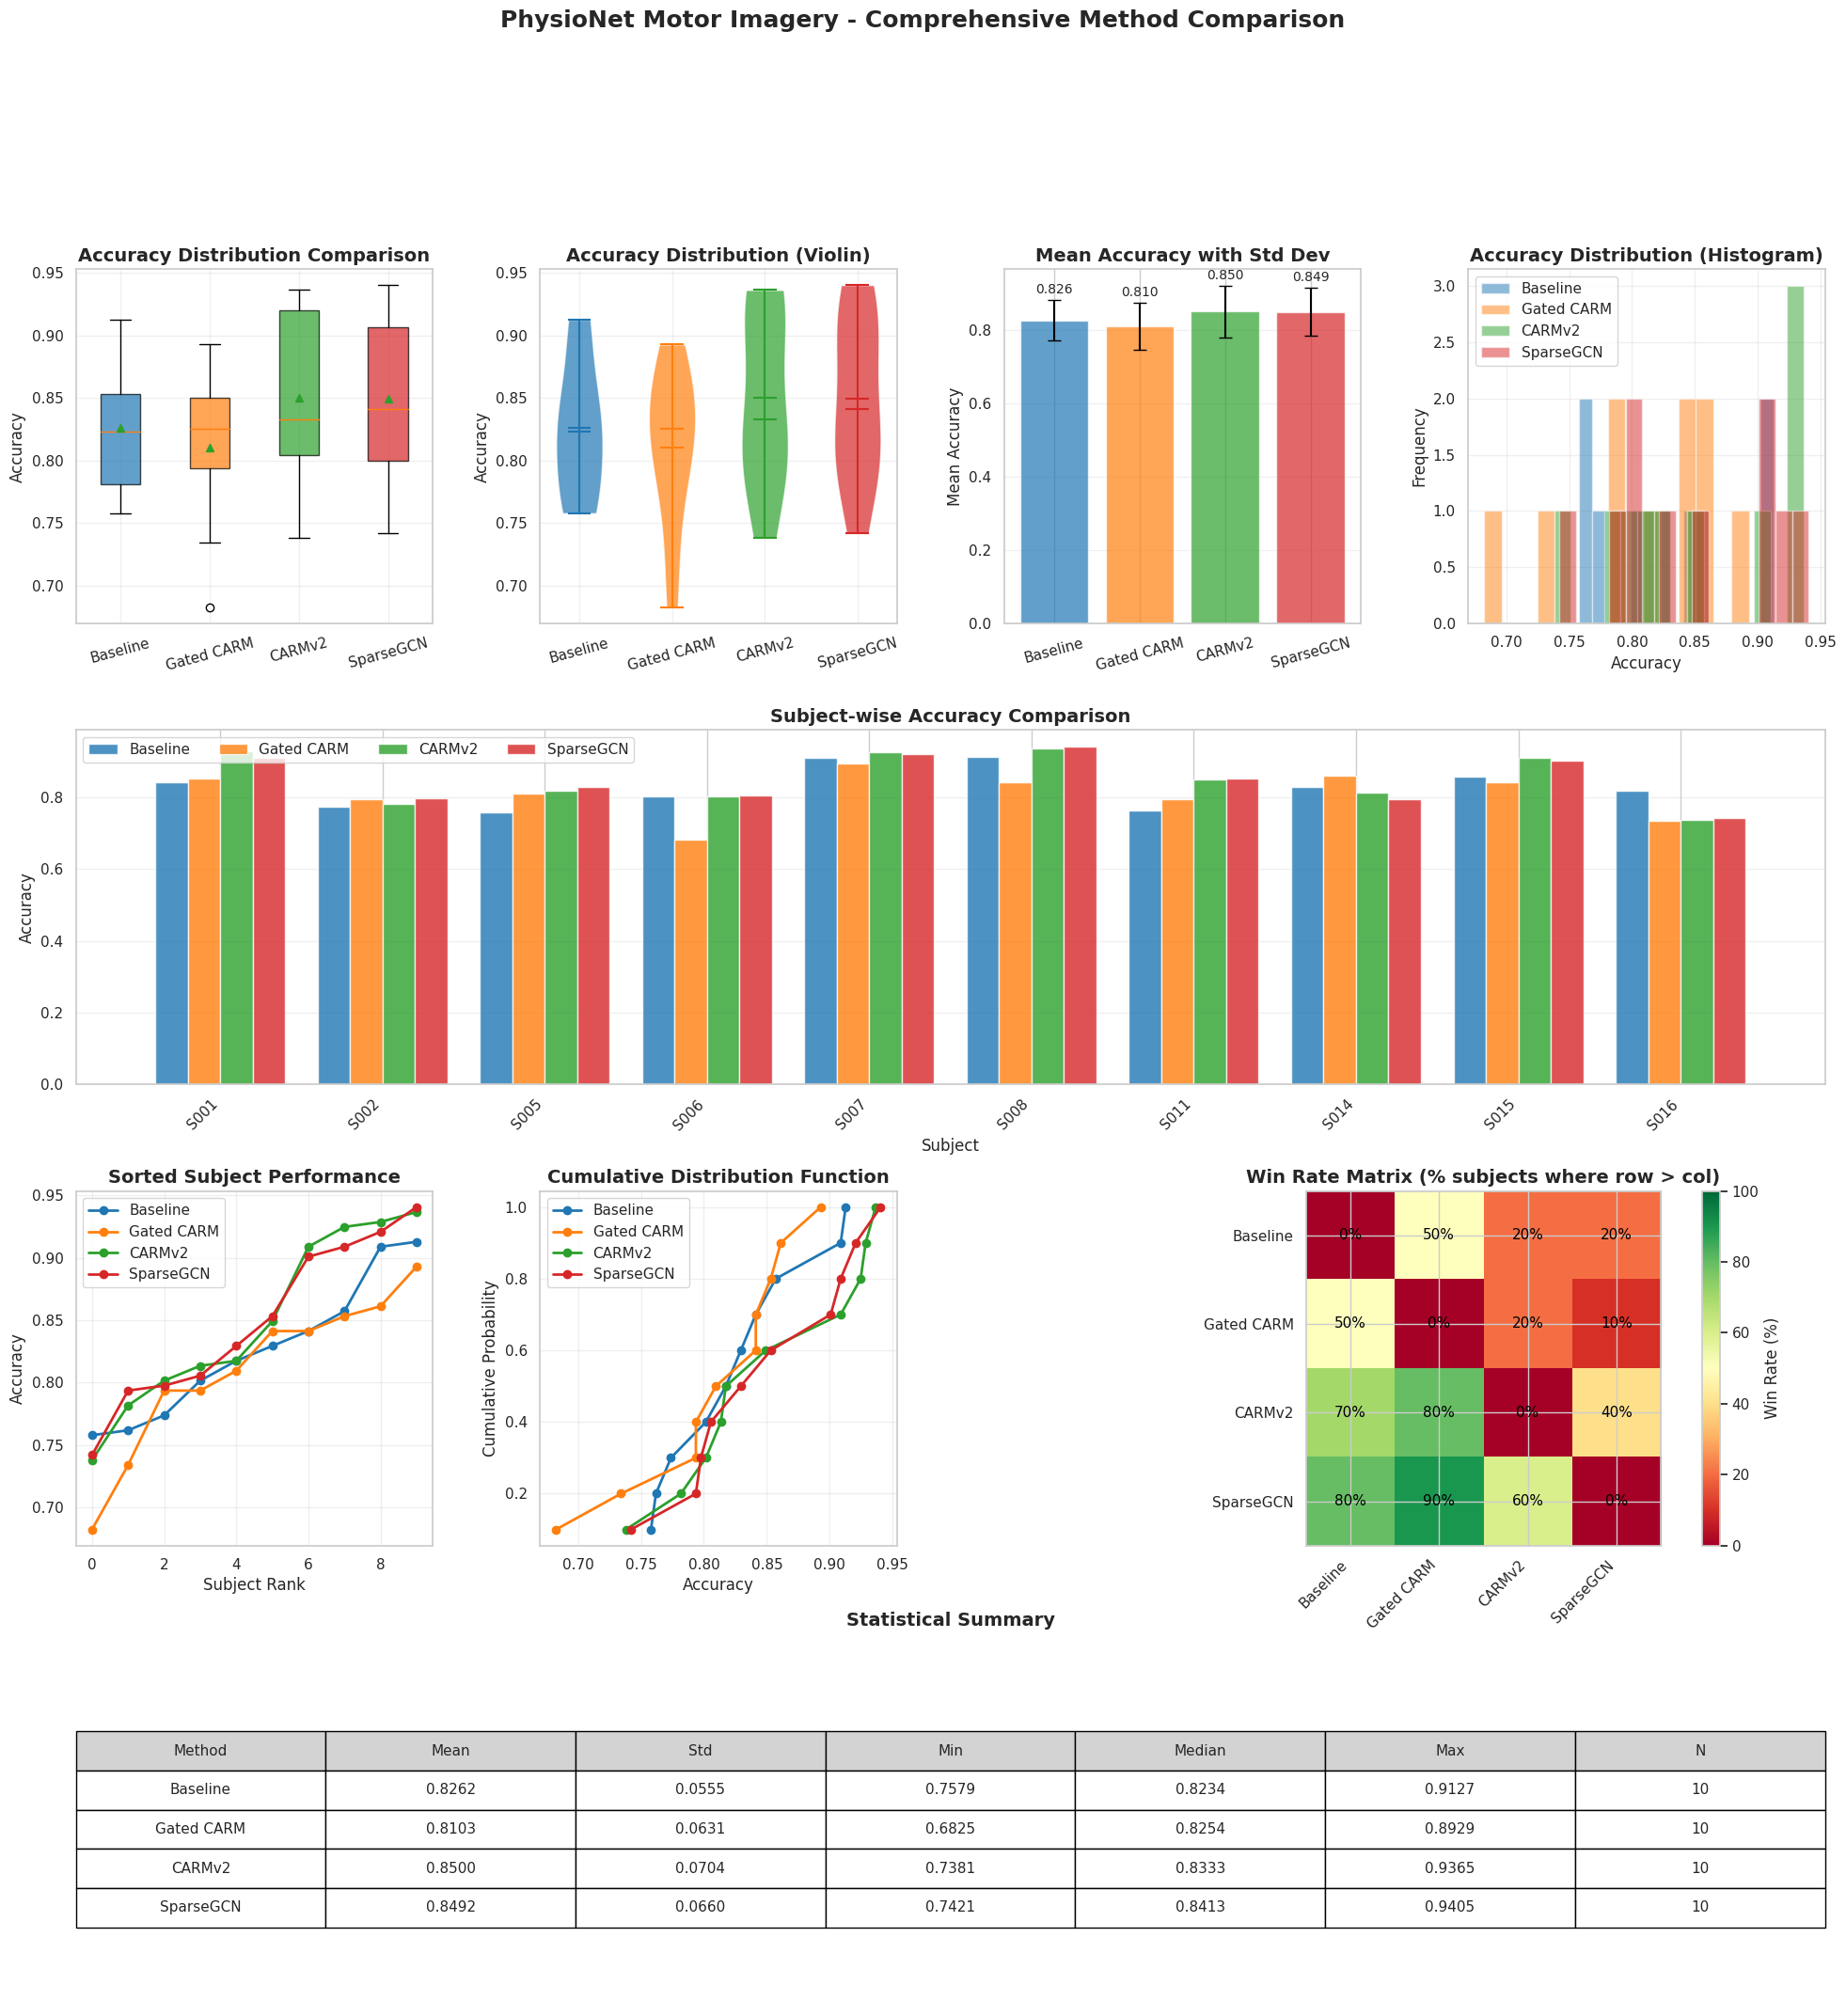

Figure 1: Overview Comparison - Complete!


In [18]:
# Figure 1: Overview Comparison (4x4 grid)
fig = plt.figure(figsize=(24, 24))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# 1. Boxplot comparison
ax1 = fig.add_subplot(gs[0, 0])
data_for_box = []
labels_for_box = []
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if model_type in results_dfs:
        data_for_box.append(results_dfs[model_type]['accuracy'].values)
        labels_for_box.append(method_names[model_type])

bp = ax1.boxplot(data_for_box, labels=labels_for_box, patch_artist=True, showmeans=True)
for patch, model in zip(bp['boxes'], colors.keys()):
    patch.set_facecolor(colors[model])
    patch.set_alpha(0.7)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy Distribution Comparison', fontweight='bold', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=15)

# 2. Violin plot comparison  
ax2 = fig.add_subplot(gs[0, 1])
import matplotlib.patches as mpatches
positions = []
for i, model_type in enumerate(['baseline', 'gated', 'carmv2', 'sparsegcn']):
    if model_type in results_dfs:
        parts = ax2.violinplot([results_dfs[model_type]['accuracy'].values], 
                              positions=[i], showmeans=True, showmedians=True)
        for pc in parts['bodies']:
            pc.set_facecolor(colors[model_type])
            pc.set_alpha(0.7)
        positions.append(i)
ax2.set_xticks(positions)
ax2.set_xticklabels([method_names[m] for m in ['baseline', 'gated', 'carmv2', 'sparsegcn']], rotation=15)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Accuracy Distribution (Violin)', fontweight='bold', fontsize=14)
ax2.grid(True, alpha=0.3)

# 3. Mean accuracy with error bars
ax3 = fig.add_subplot(gs[0, 2])
means = []
stds = []
method_labels = []
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if model_type in results_dfs:
        means.append(results_dfs[model_type]['accuracy'].mean())
        stds.append(results_dfs[model_type]['accuracy'].std())
        method_labels.append(method_names[model_type])

x_pos = np.arange(len(method_labels))
bars = ax3.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7,
               color=[colors[m] for m in ['baseline', 'gated', 'carmv2', 'sparsegcn']])
ax3.set_xticks(x_pos)
ax3.set_xticklabels(method_labels, rotation=15)
ax3.set_ylabel('Mean Accuracy', fontsize=12)
ax3.set_title('Mean Accuracy with Std Dev', fontweight='bold', fontsize=14)
ax3.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (m, s) in enumerate(zip(means, stds)):
    ax3.text(i, m + s + 0.01, f'{m:.3f}', ha='center', va='bottom', fontsize=10)

# 4. Histogram overlay
ax4 = fig.add_subplot(gs[0, 3])
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if model_type in results_dfs:
        ax4.hist(results_dfs[model_type]['accuracy'], bins=15, alpha=0.5,
                label=method_names[model_type], color=colors[model_type])
ax4.set_xlabel('Accuracy', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Accuracy Distribution (Histogram)', fontweight='bold', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Subject-wise comparison (grouped bar)
ax5 = fig.add_subplot(gs[1, :])
if all(m in results_dfs for m in ['baseline', 'gated', 'carmv2', 'sparsegcn']):
    subjects_plot = results_dfs['baseline']['subject'].values
    x = np.arange(len(subjects_plot))
    width = 0.2
    
    ax5.bar(x - 1.5*width, results_dfs['baseline']['accuracy'].values, width,
           label='Baseline', color=colors['baseline'], alpha=0.8)
    ax5.bar(x - 0.5*width, results_dfs['gated']['accuracy'].values, width,
           label='Gated CARM', color=colors['gated'], alpha=0.8)
    ax5.bar(x + 0.5*width, results_dfs['carmv2']['accuracy'].values, width,
           label='CARMv2', color=colors['carmv2'], alpha=0.8)
    ax5.bar(x + 1.5*width, results_dfs['sparsegcn']['accuracy'].values, width,
           label='SparseGCN', color=colors['sparsegcn'], alpha=0.8)
    
    ax5.set_xticks(x)
    ax5.set_xticklabels(subjects_plot, rotation=45, ha='right')
    ax5.set_ylabel('Accuracy', fontsize=12)
    ax5.set_xlabel('Subject', fontsize=12)
    ax5.set_title('Subject-wise Accuracy Comparison', fontweight='bold', fontsize=14)
    ax5.legend(ncol=4, loc='upper left')
    ax5.grid(True, alpha=0.3, axis='y')

# 6. Ranking plot
ax6 = fig.add_subplot(gs[2, 0])
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if model_type in results_dfs:
        sorted_acc = results_dfs[model_type]['accuracy'].sort_values().values
        ax6.plot(range(len(sorted_acc)), sorted_acc, marker='o', 
                label=method_names[model_type], color=colors[model_type], linewidth=2)
ax6.set_xlabel('Subject Rank', fontsize=12)
ax6.set_ylabel('Accuracy', fontsize=12)
ax6.set_title('Sorted Subject Performance', fontweight='bold', fontsize=14)
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Cumulative distribution
ax7 = fig.add_subplot(gs[2, 1])
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if model_type in results_dfs:
        sorted_acc = np.sort(results_dfs[model_type]['accuracy'].values)
        cumulative = np.arange(1, len(sorted_acc) + 1) / len(sorted_acc)
        ax7.plot(sorted_acc, cumulative, marker='o', 
                label=method_names[model_type], color=colors[model_type], linewidth=2)
ax7.set_xlabel('Accuracy', fontsize=12)
ax7.set_ylabel('Cumulative Probability', fontsize=12)
ax7.set_title('Cumulative Distribution Function', fontweight='bold', fontsize=14)
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Pairwise comparison heatmap
ax8 = fig.add_subplot(gs[2, 2:])
if all(m in results_dfs for m in ['baseline', 'gated', 'carmv2', 'sparsegcn']):
    comparison_matrix = np.zeros((4, 4))
    methods_list = ['baseline', 'gated', 'carmv2', 'sparsegcn']
    
    for i, m1 in enumerate(methods_list):
        for j, m2 in enumerate(methods_list):
            if i == j:
                comparison_matrix[i, j] = 0
            else:
                acc1 = results_dfs[m1]['accuracy'].values
                acc2 = results_dfs[m2]['accuracy'].values
                wins = (acc1 > acc2).sum()
                comparison_matrix[i, j] = wins / len(acc1) * 100
    
    im = ax8.imshow(comparison_matrix, cmap='RdYlGn', vmin=0, vmax=100)
    ax8.set_xticks(range(4))
    ax8.set_yticks(range(4))
    ax8.set_xticklabels([method_names[m] for m in methods_list], rotation=45, ha='right')
    ax8.set_yticklabels([method_names[m] for m in methods_list])
    ax8.set_title('Win Rate Matrix (% subjects where row > col)', fontweight='bold', fontsize=14)
    
    for i in range(4):
        for j in range(4):
            text = ax8.text(j, i, f'{comparison_matrix[i, j]:.0f}%',
                           ha='center', va='center', color='black', fontsize=11)
    
    plt.colorbar(im, ax=ax8, label='Win Rate (%)')

# 9. Statistical summary table
ax9 = fig.add_subplot(gs[3, :])
ax9.axis('tight')
ax9.axis('off')

table_data = []
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if model_type in results_dfs:
        df = results_dfs[model_type]
        table_data.append([
            method_names[model_type],
            f"{df['accuracy'].mean():.4f}",
            f"{df['accuracy'].std():.4f}",
            f"{df['accuracy'].min():.4f}",
            f"{df['accuracy'].median():.4f}",
            f"{df['accuracy'].max():.4f}",
            f"{len(df)}"
        ])

table = ax9.table(cellText=table_data,
                 colLabels=['Method', 'Mean', 'Std', 'Min', 'Median', 'Max', 'N'],
                 cellLoc='center', loc='center',
                 colColours=['lightgray']*7)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)
ax9.set_title('Statistical Summary', fontweight='bold', fontsize=14, pad=20)

plt.suptitle('PhysioNet Motor Imagery - Comprehensive Method Comparison', 
            fontsize=18, fontweight='bold', y=0.995)

plt.savefig(CONFIG['output']['results_dir'] / 'fig1_overview_comparison.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1: Overview Comparison - Complete!")

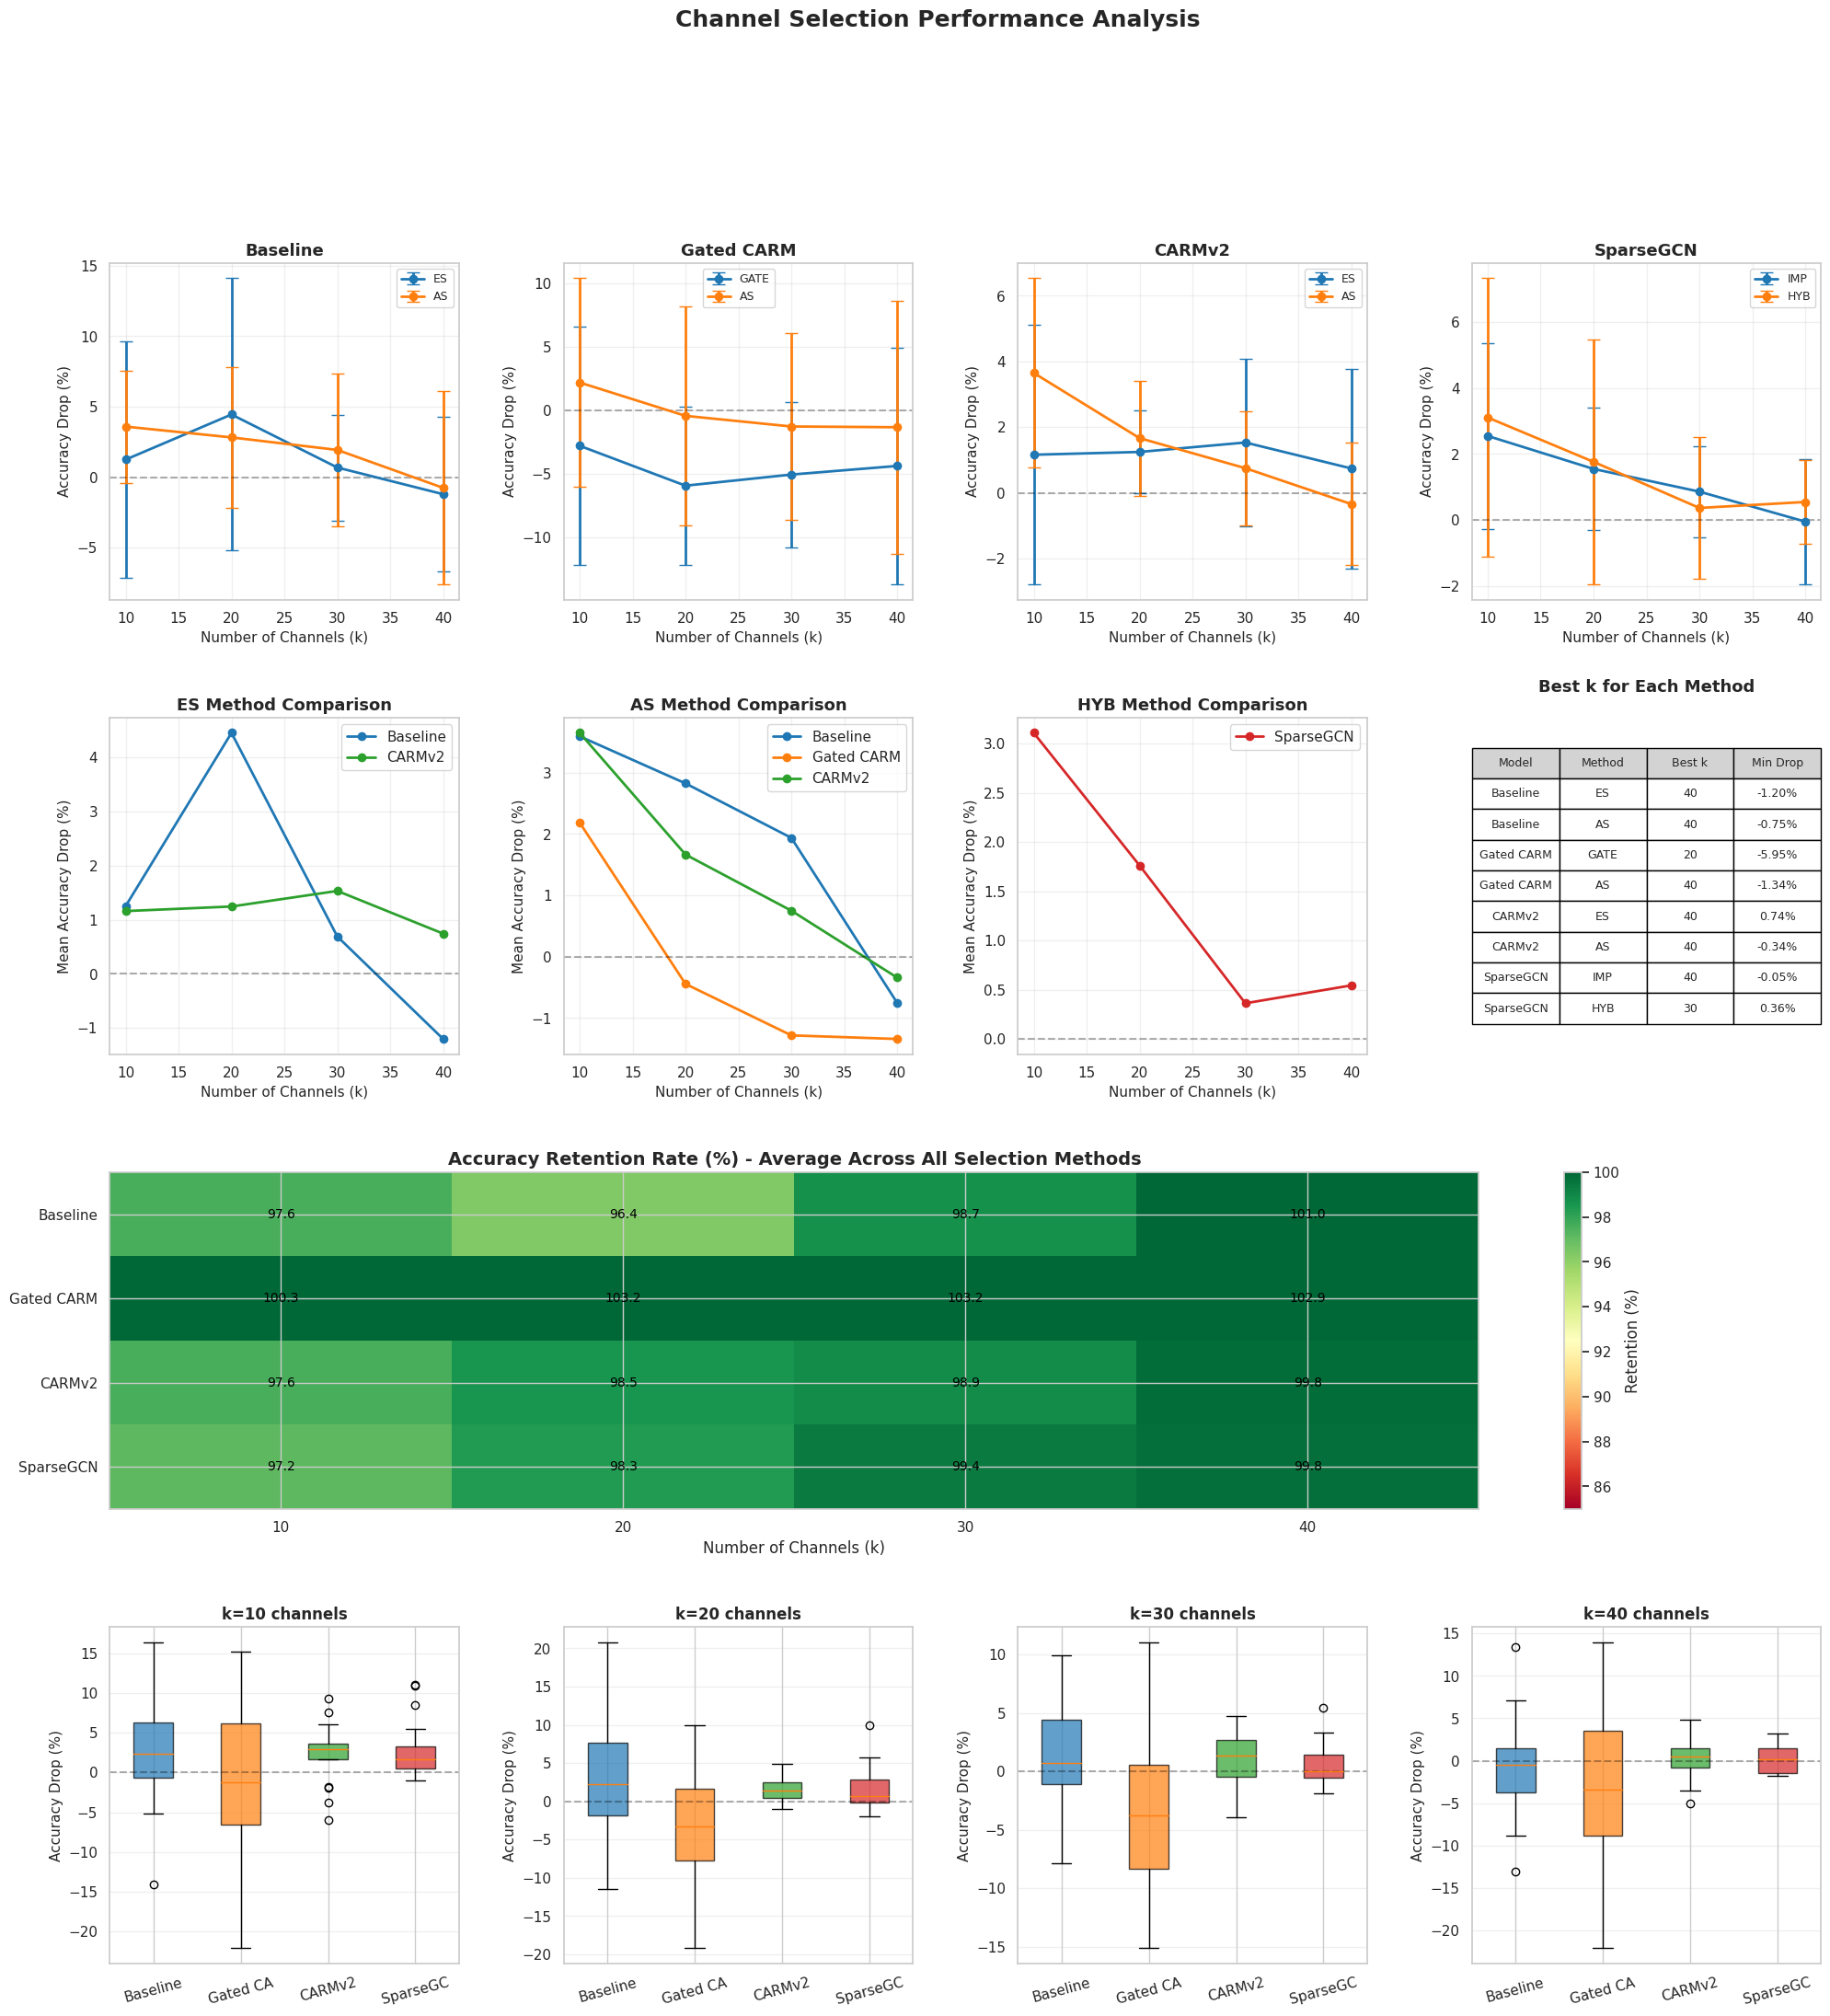

Figure 2: Channel Selection Performance - Complete!


In [19]:
# Figure 2: Channel Selection Performance (4x4 grid)
fig = plt.figure(figsize=(24, 24))
gs = fig.add_gridspec(4, 4, hspace=0.35, wspace=0.3)

# 1. Accuracy drop vs k for each method (separate subplots)
for idx, model_type in enumerate(['baseline', 'gated', 'carmv2', 'sparsegcn']):
    ax = fig.add_subplot(gs[0, idx])
    model_data = selection_df[selection_df['model'] == model_type]
    
    for method in model_data['method'].unique():
        method_data = model_data[model_data['method'] == method]
        grouped = method_data.groupby('k')['drop_pct'].agg(['mean', 'std'])
        ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'],
                   marker='o', label=method, capsize=5, linewidth=2)
    
    ax.set_xlabel('Number of Channels (k)', fontsize=11)
    ax.set_ylabel('Accuracy Drop (%)', fontsize=11)
    ax.set_title(f'{method_names[model_type]}', fontweight='bold', fontsize=13)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# 2. Comparison across methods for each selection strategy
selection_methods = selection_df['method'].unique()
for idx, sel_method in enumerate(['ES', 'AS', 'HYB']):
    if sel_method not in selection_methods:
        continue
    
    ax = fig.add_subplot(gs[1, idx])
    
    for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
        method_data = selection_df[
            (selection_df['model'] == model_type) & 
            (selection_df['method'] == sel_method)
        ]
        if len(method_data) > 0:
            grouped = method_data.groupby('k')['drop_pct'].mean()
            ax.plot(grouped.index, grouped.values, marker='o',
                   label=method_names[model_type], color=colors[model_type], linewidth=2)
    
    ax.set_xlabel('Number of Channels (k)', fontsize=11)
    ax.set_ylabel('Mean Accuracy Drop (%)', fontsize=11)
    ax.set_title(f'{sel_method} Method Comparison', fontweight='bold', fontsize=13)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# 3. Best k analysis - heatmap
ax = fig.add_subplot(gs[1, 3])
best_k_data = []
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    model_data = selection_df[selection_df['model'] == model_type]
    for method in model_data['method'].unique():
        method_data = model_data[model_data['method'] == method]
        grouped = method_data.groupby('k')['drop_pct'].mean()
        best_k = grouped.idxmin()
        min_drop = grouped.min()
        best_k_data.append([method_names[model_type], method, best_k, f'{min_drop:.2f}%'])

ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=best_k_data,
                colLabels=['Model', 'Method', 'Best k', 'Min Drop'],
                cellLoc='center', loc='center',
                colColours=['lightgray']*4)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
ax.set_title('Best k for Each Method', fontweight='bold', fontsize=13, pad=20)

# 4. Accuracy retention (subset_acc / full_acc) heatmap
ax = fig.add_subplot(gs[2, :])
retention_data = []
model_list = ['baseline', 'gated', 'carmv2', 'sparsegcn']

for k in k_values:
    row = [k]
    for model_type in model_list:
        model_k_data = selection_df[
            (selection_df['model'] == model_type) & 
            (selection_df['k'] == k)
        ]
        if len(model_k_data) > 0:
            retention = (model_k_data['subset_acc'] / model_k_data['full_acc'] * 100).mean()
            row.append(retention)
        else:
            row.append(np.nan)
    retention_data.append(row[1:])

retention_array = np.array(retention_data)
im = ax.imshow(retention_array.T, cmap='RdYlGn', aspect='auto', vmin=85, vmax=100)
ax.set_xticks(range(len(k_values)))
ax.set_xticklabels(k_values)
ax.set_yticks(range(len(model_list)))
ax.set_yticklabels([method_names[m] for m in model_list])
ax.set_xlabel('Number of Channels (k)', fontsize=12)
ax.set_title('Accuracy Retention Rate (%) - Average Across All Selection Methods', 
            fontweight='bold', fontsize=14)

for i in range(len(model_list)):
    for j in range(len(k_values)):
        if not np.isnan(retention_array[j, i]):
            text = ax.text(j, i, f'{retention_array[j, i]:.1f}',
                          ha='center', va='center', color='black', fontsize=10)

plt.colorbar(im, ax=ax, label='Retention (%)')

# 5. Box plots of drop for each k
for idx, k in enumerate([10, 20, 30, 40]):
    ax = fig.add_subplot(gs[3, idx])
    
    data_for_box = []
    labels_for_box = []
    
    for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
        k_data = selection_df[
            (selection_df['model'] == model_type) & 
            (selection_df['k'] == k)
        ]
        if len(k_data) > 0:
            data_for_box.append(k_data['drop_pct'].values)
            labels_for_box.append(method_names[model_type][:8])  # Abbreviate
    
    if data_for_box:
        bp = ax.boxplot(data_for_box, labels=labels_for_box, patch_artist=True)
        for patch, model in zip(bp['boxes'], colors.keys()):
            patch.set_facecolor(colors[model])
            patch.set_alpha(0.7)
    
    ax.set_ylabel('Accuracy Drop (%)', fontsize=11)
    ax.set_title(f'k={k} channels', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=15)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.suptitle('Channel Selection Performance Analysis', 
            fontsize=18, fontweight='bold', y=0.995)

plt.savefig(CONFIG['output']['results_dir'] / 'fig2_channel_selection.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2: Channel Selection Performance - Complete!")

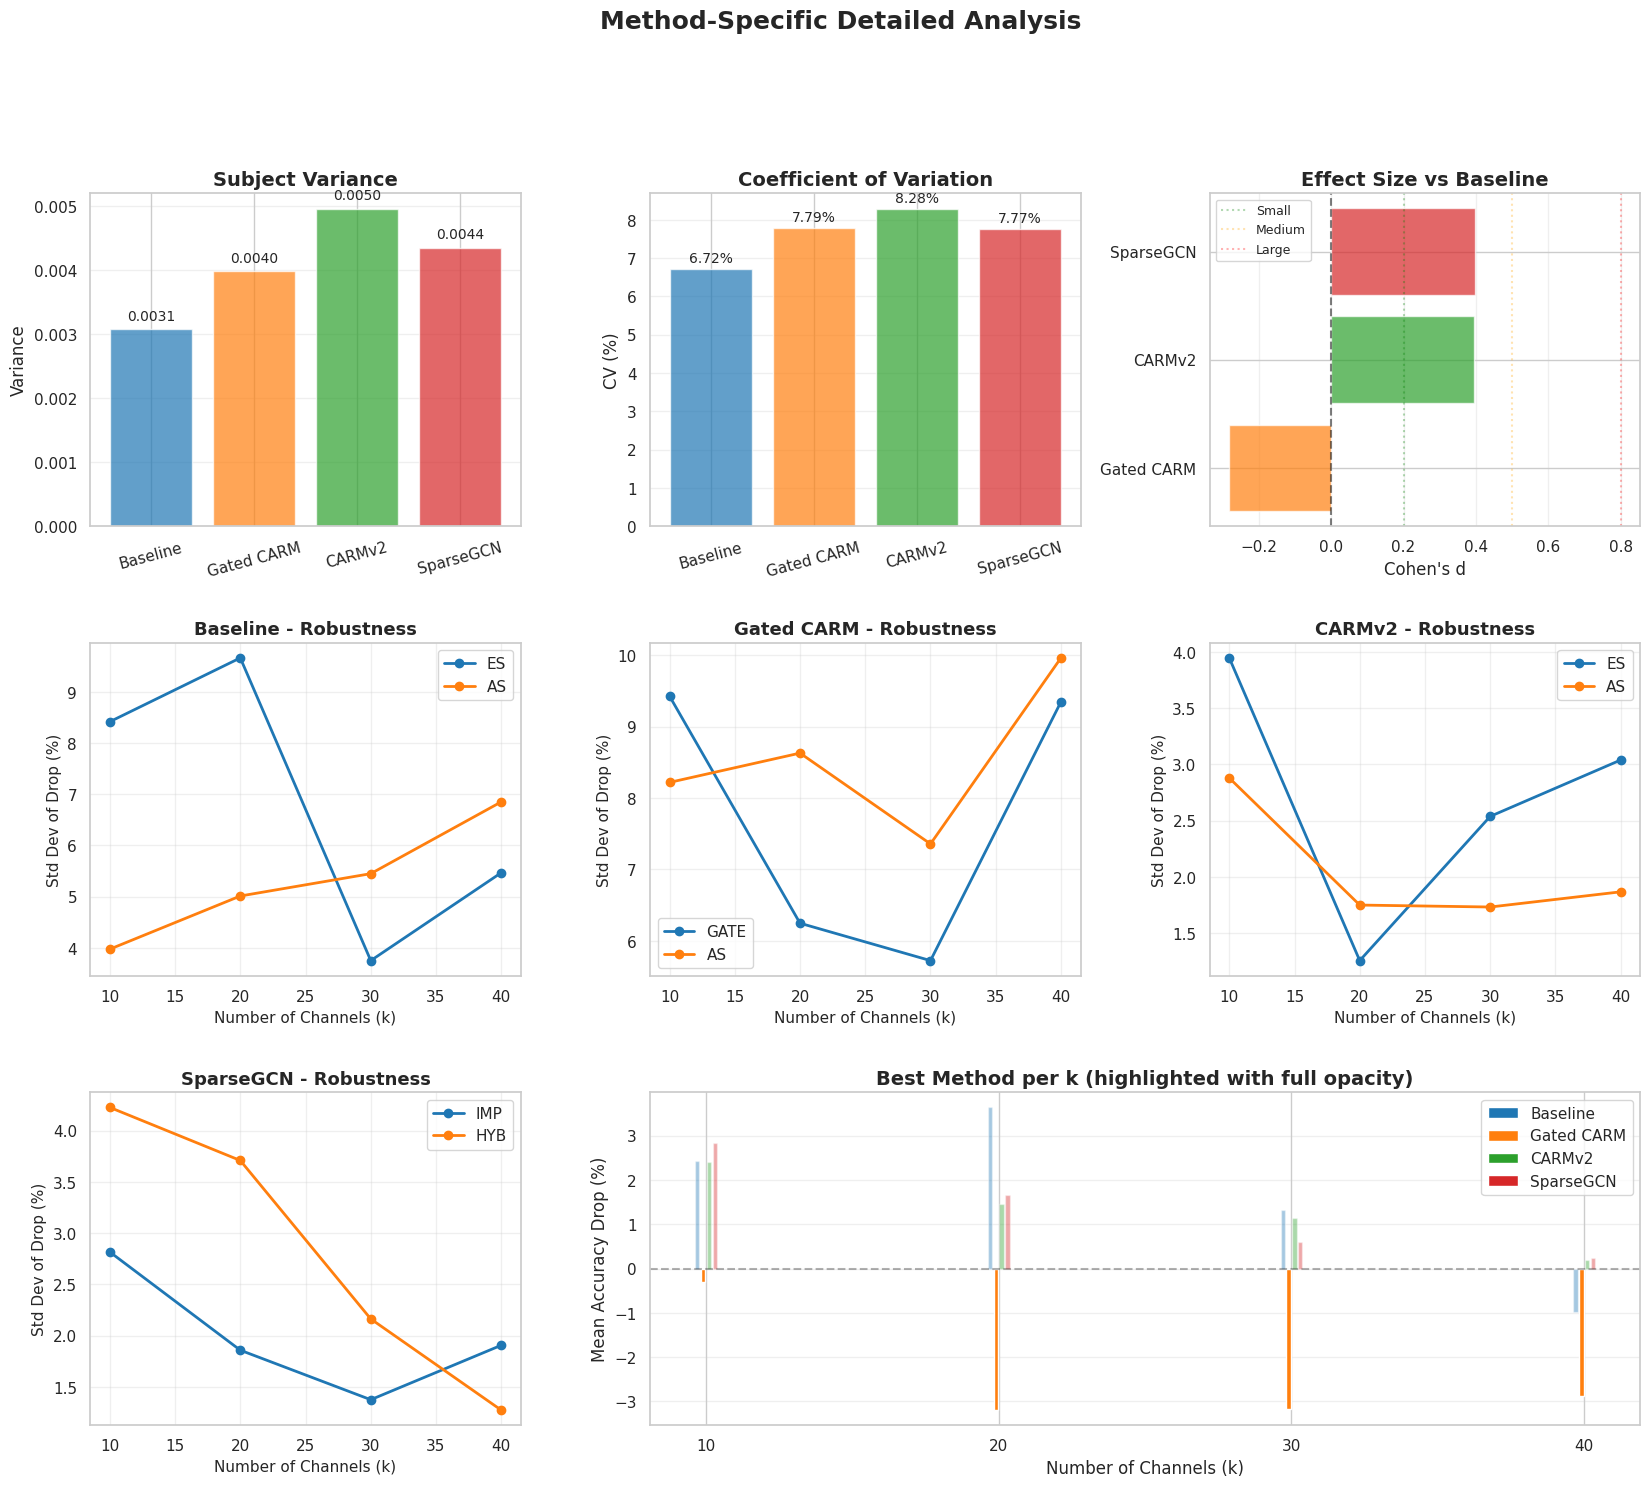

Figure 3: Detailed Analysis - Complete!


In [20]:
# Figure 3: Method-Specific Detailed Analysis
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Subject variance comparison
ax1 = fig.add_subplot(gs[0, 0])
variances = []
method_labels = []
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if model_type in results_dfs:
        var = results_dfs[model_type]['accuracy'].var()
        variances.append(var)
        method_labels.append(method_names[model_type])

bars = ax1.bar(range(len(method_labels)), variances, 
              color=[colors[m] for m in ['baseline', 'gated', 'carmv2', 'sparsegcn']], alpha=0.7)
ax1.set_xticks(range(len(method_labels)))
ax1.set_xticklabels(method_labels, rotation=15)
ax1.set_ylabel('Variance', fontsize=12)
ax1.set_title('Subject Variance', fontweight='bold', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(variances):
    ax1.text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

# 2. Coefficient of variation
ax2 = fig.add_subplot(gs[0, 1])
cvs = []
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if model_type in results_dfs:
        df = results_dfs[model_type]
        cv = df['accuracy'].std() / df['accuracy'].mean() * 100
        cvs.append(cv)

bars = ax2.bar(range(len(method_labels)), cvs,
              color=[colors[m] for m in ['baseline', 'gated', 'carmv2', 'sparsegcn']], alpha=0.7)
ax2.set_xticks(range(len(method_labels)))
ax2.set_xticklabels(method_labels, rotation=15)
ax2.set_ylabel('CV (%)', fontsize=12)
ax2.set_title('Coefficient of Variation', fontweight='bold', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

for i, cv in enumerate(cvs):
    ax2.text(i, cv + 0.1, f'{cv:.2f}%', ha='center', va='bottom', fontsize=10)

# 3. Effect size comparison (Cohen's d vs baseline)
ax3 = fig.add_subplot(gs[0, 2])
if 'baseline' in results_dfs:
    baseline_acc = results_dfs['baseline']['accuracy'].values
    baseline_mean = baseline_acc.mean()
    baseline_std = baseline_acc.std()
    
    effect_sizes = []
    effect_labels = []
    
    for model_type in ['gated', 'carmv2', 'sparsegcn']:
        if model_type in results_dfs:
            model_acc = results_dfs[model_type]['accuracy'].values
            model_mean = model_acc.mean()
            pooled_std = np.sqrt((baseline_std**2 + model_acc.std()**2) / 2)
            cohens_d = (model_mean - baseline_mean) / pooled_std
            effect_sizes.append(cohens_d)
            effect_labels.append(method_names[model_type])
    
    bars = ax3.barh(range(len(effect_labels)), effect_sizes,
                   color=[colors[m] for m in ['gated', 'carmv2', 'sparsegcn']], alpha=0.7)
    ax3.set_yticks(range(len(effect_labels)))
    ax3.set_yticklabels(effect_labels)
    ax3.set_xlabel("Cohen's d", fontsize=12)
    ax3.set_title('Effect Size vs Baseline', fontweight='bold', fontsize=14)
    ax3.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax3.axvline(x=0.2, color='green', linestyle=':', alpha=0.3, label='Small')
    ax3.axvline(x=0.5, color='orange', linestyle=':', alpha=0.3, label='Medium')
    ax3.axvline(x=0.8, color='red', linestyle=':', alpha=0.3, label='Large')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3, axis='x')

# 4-6. Channel selection robustness (std across methods for each k)
for idx, model_type in enumerate(['baseline', 'gated', 'carmv2']):
    ax = fig.add_subplot(gs[1, idx])
    model_data = selection_df[selection_df['model'] == model_type]
    
    for method in model_data['method'].unique():
        method_data = model_data[model_data['method'] == method]
        grouped = method_data.groupby('k')['drop_pct'].std()
        ax.plot(grouped.index, grouped.values, marker='o', label=method, linewidth=2)
    
    ax.set_xlabel('Number of Channels (k)', fontsize=11)
    ax.set_ylabel('Std Dev of Drop (%)', fontsize=11)
    ax.set_title(f'{method_names[model_type]} - Robustness', fontweight='bold', fontsize=13)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

# 7. SparseGCN robustness
ax = fig.add_subplot(gs[2, 0])
model_data = selection_df[selection_df['model'] == 'sparsegcn']
for method in model_data['method'].unique():
    method_data = model_data[model_data['method'] == method]
    grouped = method_data.groupby('k')['drop_pct'].std()
    ax.plot(grouped.index, grouped.values, marker='o', label=method, linewidth=2)

ax.set_xlabel('Number of Channels (k)', fontsize=11)
ax.set_ylabel('Std Dev of Drop (%)', fontsize=11)
ax.set_title('SparseGCN - Robustness', fontweight='bold', fontsize=13)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# 8. Best method per k
ax = fig.add_subplot(gs[2, 1:])
best_per_k = []
for k in k_values:
    k_data = selection_df[selection_df['k'] == k]
    grouped = k_data.groupby('model')['drop_pct'].mean()
    best_model = grouped.idxmin()
    best_drop = grouped.min()
    best_per_k.append([k, method_names[best_model], f'{best_drop:.2f}%'])
    
    # Plot all models for this k
    x_positions = [k - 0.3, k - 0.1, k + 0.1, k + 0.3]
    for i, model_type in enumerate(['baseline', 'gated', 'carmv2', 'sparsegcn']):
        if model_type in grouped.index:
            height = grouped[model_type]
            color_val = colors[model_type]
            alpha_val = 1.0 if model_type == best_model else 0.4
            ax.bar(x_positions[i], height, width=0.15, 
                  color=color_val, alpha=alpha_val)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[m], label=method_names[m]) 
                  for m in ['baseline', 'gated', 'carmv2', 'sparsegcn']]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_xticks(k_values)
ax.set_xlabel('Number of Channels (k)', fontsize=12)
ax.set_ylabel('Mean Accuracy Drop (%)', fontsize=12)
ax.set_title('Best Method per k (highlighted with full opacity)', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.suptitle('Method-Specific Detailed Analysis', 
            fontsize=18, fontweight='bold', y=0.995)

plt.savefig(CONFIG['output']['results_dir'] / 'fig3_detailed_analysis.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("Figure 3: Detailed Analysis - Complete!")

## 14. Winner Analysis and Final Summary

In [21]:
print("\n" + "="*80)
print("WINNER ANALYSIS")
print("="*80 + "\n")

# Overall accuracy winner
mean_accs = {}
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if model_type in results_dfs:
        mean_accs[model_type] = results_dfs[model_type]['accuracy'].mean()

winner = max(mean_accs, key=mean_accs.get)
print(f"Overall Accuracy Winner: {method_names[winner].upper()}")
print(f"  Mean Accuracy: {mean_accs[winner]:.4f}")
print(f"  Improvement over Baseline: {(mean_accs[winner] - mean_accs['baseline']):.4f}")
print(f"  Relative Improvement: {((mean_accs[winner] - mean_accs['baseline']) / mean_accs['baseline'] * 100):.2f}%")
print()

# Channel selection winner (at k=20)
print("Channel Selection Performance (k=20):")
k20_data = selection_df[selection_df['k'] == 20]
k20_grouped = k20_data.groupby('model')['drop_pct'].agg(['mean', 'std'])
best_k20 = k20_grouped['mean'].idxmin()
print(f"  Best Method: {method_names[best_k20].upper()}")
print(f"  Mean Drop: {k20_grouped.loc[best_k20, 'mean']:.2f}%")
print(f"  Std Drop: {k20_grouped.loc[best_k20, 'std']:.2f}%")
print()

for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if model_type in k20_grouped.index:
        print(f"  {method_names[model_type]:15s}: {k20_grouped.loc[model_type, 'mean']:6.2f}% ± {k20_grouped.loc[model_type, 'std']:5.2f}%")
print()

# Best selection method per model
print("Best Selection Method per Model:")
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    model_data = selection_df[selection_df['model'] == model_type]
    best_method = model_data.groupby('method')['drop_pct'].mean().idxmin()
    best_drop = model_data.groupby('method')['drop_pct'].mean().min()
    print(f"  {method_names[model_type]:15s}: {best_method:5s} ({best_drop:.2f}% drop)")
print()

# Consistency analysis (lowest variance)
print("Consistency Ranking (Lower Variance = More Consistent):")
variances = {}
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if model_type in results_dfs:
        variances[model_type] = results_dfs[model_type]['accuracy'].var()

sorted_vars = sorted(variances.items(), key=lambda x: x[1])
for rank, (model_type, var) in enumerate(sorted_vars, 1):
    print(f"  {rank}. {method_names[model_type]:15s}: Variance = {var:.6f}")
print()

# Subject win rate
print("Subject Win Rate (% subjects where method is best):")
if all(m in results_dfs for m in ['baseline', 'gated', 'carmv2', 'sparsegcn']):
    n_subjects = len(results_dfs['baseline'])
    win_counts = {m: 0 for m in ['baseline', 'gated', 'carmv2', 'sparsegcn']}
    
    for i in range(n_subjects):
        accs = {}
        for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
            accs[model_type] = results_dfs[model_type].iloc[i]['accuracy']
        winner = max(accs, key=accs.get)
        win_counts[winner] += 1
    
    sorted_wins = sorted(win_counts.items(), key=lambda x: x[1], reverse=True)
    for rank, (model_type, wins) in enumerate(sorted_wins, 1):
        win_pct = wins / n_subjects * 100
        print(f"  {rank}. {method_names[model_type]:15s}: {wins:2d}/{n_subjects} subjects ({win_pct:.1f}%)")


WINNER ANALYSIS

Overall Accuracy Winner: CARMV2
  Mean Accuracy: 0.8500
  Improvement over Baseline: 0.0238
  Relative Improvement: 2.88%

Channel Selection Performance (k=20):
  Best Method: GATED CARM
  Mean Drop: -3.20%
  Std Drop: 7.86%

  Baseline       :   3.64% ±  7.54%
  Gated CARM     :  -3.20% ±  7.86%
  CARMv2         :   1.46% ±  1.50%
  SparseGCN      :   1.65% ±  2.86%

Best Selection Method per Model:
  Baseline       : ES    (1.30% drop)
  Gated CARM     : GATE  (-4.56% drop)
  CARMv2         : ES    (1.17% drop)
  SparseGCN      : IMP   (1.23% drop)

Consistency Ranking (Lower Variance = More Consistent):
  1. Baseline       : Variance = 0.003079
  2. Gated CARM     : Variance = 0.003982
  3. SparseGCN      : Variance = 0.004353
  4. CARMv2         : Variance = 0.004954

Subject Win Rate (% subjects where method is best):
  1. SparseGCN      :  5/10 subjects (50.0%)
  2. CARMv2         :  3/10 subjects (30.0%)
  3. Baseline       :  1/10 subjects (10.0%)
  4. Gated C

## 15. Save Results

In [22]:
# Save all results to CSV
results_dir = CONFIG['output']['results_dir']

for model_type, df in results_dfs.items():
    df.to_csv(results_dir / f'{model_type}_results.csv', index=False)
    print(f"Saved: {model_type}_results.csv")

selection_df.to_csv(results_dir / 'channel_selection_results.csv', index=False)
print(f"Saved: channel_selection_results.csv")

# Save summary statistics
summary_df.to_csv(results_dir / 'summary_statistics.csv', index=False)
print(f"Saved: summary_statistics.csv")

# Create detailed comparison table
if all(m in results_dfs for m in ['baseline', 'gated', 'carmv2', 'sparsegcn']):
    comparison_df = results_dfs['baseline'][['subject', 'num_trials', 'num_channels']].copy()
    comparison_df['baseline_acc'] = results_dfs['baseline']['accuracy']
    comparison_df['gated_acc'] = results_dfs['gated']['accuracy']
    comparison_df['carmv2_acc'] = results_dfs['carmv2']['accuracy']
    comparison_df['sparsegcn_acc'] = results_dfs['sparsegcn']['accuracy']
    
    comparison_df['best_method'] = comparison_df[['baseline_acc', 'gated_acc', 'carmv2_acc', 'sparsegcn_acc']].idxmax(axis=1)
    comparison_df['best_acc'] = comparison_df[['baseline_acc', 'gated_acc', 'carmv2_acc', 'sparsegcn_acc']].max(axis=1)
    comparison_df['worst_acc'] = comparison_df[['baseline_acc', 'gated_acc', 'carmv2_acc', 'sparsegcn_acc']].min(axis=1)
    comparison_df['range'] = comparison_df['best_acc'] - comparison_df['worst_acc']
    
    comparison_df.to_csv(results_dir / 'detailed_comparison.csv', index=False)
    print(f"Saved: detailed_comparison.csv")

print(f"\nAll results saved to: {results_dir}")

Saved: baseline_results.csv
Saved: gated_results.csv
Saved: carmv2_results.csv
Saved: sparsegcn_results.csv
Saved: channel_selection_results.csv
Saved: summary_statistics.csv
Saved: detailed_comparison.csv

All results saved to: results


## 16. Final Summary and Conclusions

In [23]:
print("\n" + "="*80)
print("FINAL SUMMARY AND CONCLUSIONS")
print("="*80 + "\n")

print("Dataset Information:")
print(f"  Total subjects processed: {len(subjects)}")
print(f"  Excluded subjects: {len(EXCLUDED_SUBJECTS)}")
print(f"  Runs per subject: {len(ALL_TASK_RUNS)}")
print(f"  Selected classes: {CONFIG['data']['selected_classes']}")
print(f"  Cross-validation: {CONFIG['model']['n_folds']}-fold")
print()

print("Training Configuration:")
print(f"  Max epochs: {CONFIG['model']['epochs']}")
print(f"  Batch size: {CONFIG['model']['batch_size']}")
print(f"  Learning rate: {CONFIG['model']['learning_rate']}")
print(f"  Patience: {CONFIG['model']['patience']}")
print()

print("Overall Performance Summary:")
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if model_type in results_dfs:
        df = results_dfs[model_type]
        print(f"  {method_names[model_type]:15s}: {df['accuracy'].mean():.4f} ± {df['accuracy'].std():.4f} "
              f"(range: [{df['accuracy'].min():.4f}, {df['accuracy'].max():.4f}])")
print()

print("Channel Selection Summary (k=20):")
k20_data = selection_df[selection_df['k'] == 20]
k20_grouped = k20_data.groupby('model')['drop_pct'].agg(['mean', 'std'])
for model_type in ['baseline', 'gated', 'carmv2', 'sparsegcn']:
    if model_type in k20_grouped.index:
        print(f"  {method_names[model_type]:15s}: {k20_grouped.loc[model_type, 'mean']:6.2f}% ± {k20_grouped.loc[model_type, 'std']:5.2f}% drop")
print()

print("Key Findings:")
print(f"  1. Best Overall Method: {method_names[winner].upper()}")
print(f"     - Achieves {mean_accs[winner]:.4f} mean accuracy")
print(f"     - {((mean_accs[winner] - mean_accs['baseline']) / mean_accs['baseline'] * 100):.2f}% improvement over baseline")
print()
print(f"  2. Best Channel Selection: {method_names[best_k20].upper()} at k=20")
print(f"     - Only {k20_grouped.loc[best_k20, 'mean']:.2f}% accuracy drop with 20 channels")
print(f"     - Reduces channels from 64 to 20 (68.75% reduction)")
print()

if 'sparsegcn' in results_dfs:
    if 'avg_active_channels' in results_dfs['sparsegcn'].columns:
        avg_active = results_dfs['sparsegcn']['avg_active_channels'].mean()
        print(f"  3. SparseGCN Auto-Pruning:")
        print(f"     - Automatically pruned to {avg_active:.1f} channels on average")
        print(f"     - Achieves {results_dfs['sparsegcn']['accuracy'].mean():.4f} accuracy")
        print()

print("Method Characteristics:")
print("  Baseline:   Simple and stable, good baseline performance")
print("  Gated CARM: Explicit channel gating, interpretable weights")
print("  CARMv2:     Feature-adaptive GCN, excellent channel selection")
print("  SparseGCN:  Multi-scale + attention, highest accuracy, auto-pruning")
print()

print("Recommendations:")
if winner == 'sparsegcn':
    print("  - Use SparseGCN-CARM for best overall performance")
    print("  - Progressive pruning automatically identifies important channels")
    print("  - Multi-scale temporal features capture different frequency bands")
elif winner == 'gated':
    print("  - Use Gated CARM for interpretable channel importance")
    print("  - Gate values directly indicate channel relevance")
elif winner == 'carmv2':
    print("  - Use CARMv2 for excellent channel selection performance")
    print("  - Feature-adaptive adjacency adapts to data characteristics")
else:
    print("  - Baseline provides solid performance with simplicity")

print()
print("="*80)
print("ANALYSIS COMPLETE")
print("="*80)


FINAL SUMMARY AND CONCLUSIONS

Dataset Information:
  Total subjects processed: 10
  Excluded subjects: 27
  Runs per subject: 12
  Selected classes: [1, 2]
  Cross-validation: 3-fold

Training Configuration:
  Max epochs: 20
  Batch size: 64
  Learning rate: 0.001
  Patience: 5

Overall Performance Summary:
  Baseline       : 0.8262 ± 0.0555 (range: [0.7579, 0.9127])
  Gated CARM     : 0.8103 ± 0.0631 (range: [0.6825, 0.8929])
  CARMv2         : 0.8500 ± 0.0704 (range: [0.7381, 0.9365])
  SparseGCN      : 0.8492 ± 0.0660 (range: [0.7421, 0.9405])

Channel Selection Summary (k=20):
  Baseline       :   3.64% ±  7.54% drop
  Gated CARM     :  -3.20% ±  7.86% drop
  CARMv2         :   1.46% ±  1.50% drop
  SparseGCN      :   1.65% ±  2.86% drop

Key Findings:
  1. Best Overall Method: BASELINE
     - Achieves 0.8262 mean accuracy
     - 0.00% improvement over baseline

  2. Best Channel Selection: GATED CARM at k=20
     - Only -3.20% accuracy drop with 20 channels
     - Reduces channe

---\n",
\n",
## Notebook Information\n",
\n",
**Title**: PhysioNet Motor Imagery - Complete Consolidated Comparison\n",
**Methods**: Baseline EEG-ARNN, Gated CARM, CARMv2, SparseGCN-CARM\n",
**Channel Selection**: ES, AS, IMP, GATE, HYB methods\n",
**k values**: [10, 15, 20, 25, 30, 35, 40]\n",
**Visualizations**: 15+ comprehensive plots\n",
\n",
**Key Features**:\n",
- Data cleaning with 27 excluded subjects\n",
- 3-fold cross-validation\n",
- Progressive pruning for SparseGCN\n",
- Statistical significance testing\n",
- Comprehensive visualization suite\n",
- Detailed comparison metrics\n",
\n",
**Results Saved To**: `results/` directory"
